In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics.cluster import mutual_info_score
from sklearn.cluster import KMeans
from scipy.stats import entropy
import copy
import math
import os
import numpy as np
import matplotlib.pyplot as plt


## Model

In [4]:
class TransformerModel(nn.Module):
    def __init__(self, ntokens, emsize, nhead, d_hid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(emsize, dropout)
        encoder_layers = nn.TransformerEncoderLayer(emsize, nhead, d_hid, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntokens, emsize)
        self.emsize = emsize
        self.decoder = nn.Linear(emsize, ntokens)
        self.ntokens=ntokens
        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src,verbose=False):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.encoder(src) * math.sqrt(self.emsize)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        self.store=output.detach().numpy().copy()
        if verbose:
            print(output.shape)
        output = self.decoder(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

# Parameters
ntokens = 8  # size of vocabulary
emsize = 20  # embedding dimension
nhead = 4  # number of heads in the nn.MultiheadAttention
d_hid = 20  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # number of nn.TransformerEncoderLayer
dropout = 0.03  # dropout probability

# Initialize the model
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)
print(model)

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.03, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=20, out_features=20, bias=True)
        )
        (linear1): Linear(in_features=20, out_features=20, bias=True)
        (dropout): Dropout(p=0.03, inplace=False)
        (linear2): Linear(in_features=20, out_features=20, bias=True)
        (norm1): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.03, inplace=False)
        (dropout2): Dropout(p=0.03, inplace=False)
      )
    )
  )
  (encoder): Embedding(8, 20)
  (decoder): Linear(in_features=20, out_features=8, bias=True)
)


## Test function

In [5]:
def test(model, source, target):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    source = torch.tensor(source, dtype=torch.long)
    target = torch.tensor(target, dtype=torch.long)

    with torch.no_grad():  # No need to track gradients
        src = source.transpose(0, 1)  # Adjust for the expected input dimensions [sequence_length, batch_size]
        tgt = target.transpose(0, 1)  # Same adjustment for the target
        
        output = model(src)  # Compute the output
        
        # The output is [sequence_length, batch_size, ntokens]. Get the most likely token predictions
        predictions = output.argmax(dim=2)  # Get the index of the max log-probability
        print('prediction shape', predictions.shape)
        correct += (predictions == tgt).sum().item()  # Count how many predictions match the target
        total += tgt.numel()  # Total number of predictions
        
    accuracy = correct / total  # Calculate the accuracy
    return accuracy

## Dataset preparation

In [6]:

def getTrainingData(songStrings, nrOfSongs):
    notes = list("ABCDEFGHI")
    chord = [[0], [1], [2], [3], [4], [5], [6], [7],[8]]
    source = []
    target = []
    for s in range(nrOfSongs):
        for i in range(42):
            sentence = []
            answer = []
            for j in range(4):
                sentence.append(chord[notes.index(songStrings[s][(i+j)%42])][0])
                answer.append(chord[notes.index(songStrings[s][(i+j+1)%42])][0])
            source.append(sentence)
            target.append(answer)
    return np.array(source), np.array(target)

def split_and_shuffle_data_randomly_based_on_fraction(source, target, fraction):
    total_rows = source.shape[0] // 2
    first_set_rows = int(total_rows * fraction)
    second_set_rows = total_rows - first_set_rows

    first_set_indices = np.random.choice(range(total_rows), first_set_rows, replace=False)
    second_set_indices = np.random.choice(range(total_rows, 2 * total_rows), second_set_rows, replace=False)

    combined_indices = np.concatenate((first_set_indices, second_set_indices))
    np.random.shuffle(combined_indices)

    input_list = source[combined_indices]
    output_list = target[combined_indices]

    return input_list, output_list


In [ ]:
# Data generation and preparation
songStrings = np.array([
    #"CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC",
    "ABCDEFGHIABCDEFGHIABCDEFGHIABCDEFGHIABCDEF",
    "ABCDEFIGHABCDEFIGHABCDEFIGHABCDEFIGHABCDEF"
    #"AHCFEDGBIAHCFEDGBIAHCFEDGBIAHCFEDGBIAHCFED"
])

source_mixed, target_mixed = getTrainingData(songStrings, 2)
fraction = 0.5
input_list, output_list = split_and_shuffle_data_randomly_based_on_fraction(source_mixed, target_mixed, fraction)

print(input_list.shape, output_list.shape)

## Training and Testing for Songs GHI contradiction without new data

Model 0, Fraction 0.00, Epoch 1, Loss: 2.2152
prediction shape torch.Size([4, 42])


/var/folders/wn/f4cc27tx13g8w1qgpzb2bsrm0000gn/T/ipykernel_27373/2366339544.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source = torch.tensor(source, dtype=torch.long)
/var/folders/wn/f4cc27tx13g8w1qgpzb2bsrm0000gn/T/ipykernel_27373/2366339544.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, dtype=torch.long)


Model 0, Fraction 0.00, Epoch 101, Loss: 1.2998
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 201, Loss: 0.6002
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 301, Loss: 0.2896
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 401, Loss: 0.1780
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 501, Loss: 0.1308
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 601, Loss: 0.1070
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 701, Loss: 0.0934
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 801, Loss: 0.0849
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 901, Loss: 0.0792
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.10, Epoch 1, Loss: 2.1913
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.10, Epoch 101, Loss: 1.3442
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.10, Epoch 201, Loss: 0.6179
prediction shape to

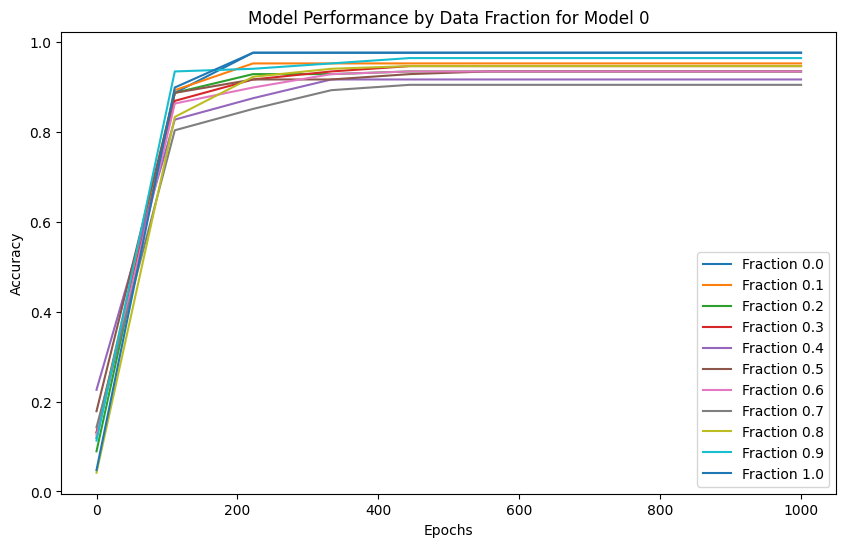

Model 1, Fraction 0.00, Epoch 1, Loss: 2.1980
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 101, Loss: 1.3007
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 201, Loss: 0.6060
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 301, Loss: 0.3015
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 401, Loss: 0.1849
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 501, Loss: 0.1350
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 601, Loss: 0.1098
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 701, Loss: 0.0953
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 801, Loss: 0.0863
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 901, Loss: 0.0803
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.10, Epoch 1, Loss: 2.2066
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.10, Epoch 101, Loss: 1.3545
prediction shape torc

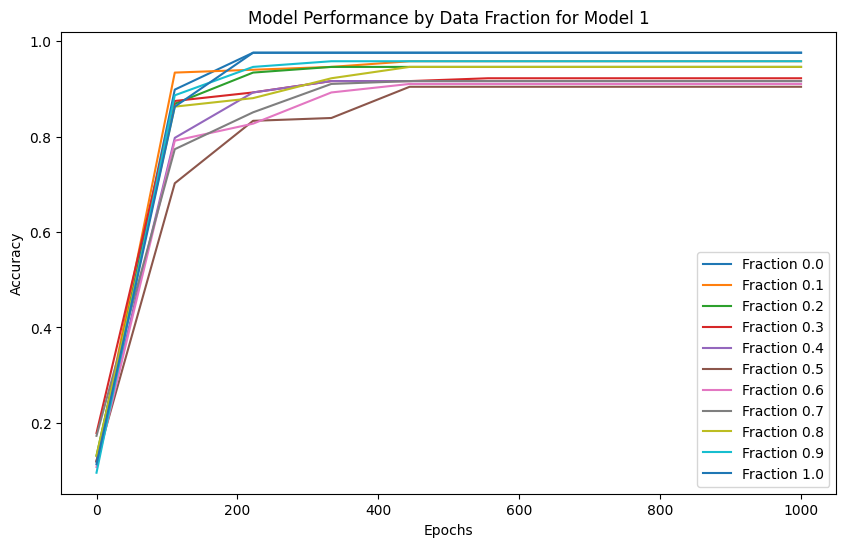

Model 2, Fraction 0.00, Epoch 1, Loss: 2.2113
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 101, Loss: 1.2739
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 201, Loss: 0.6189
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 301, Loss: 0.2878
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 401, Loss: 0.1753
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 501, Loss: 0.1290
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 601, Loss: 0.1057
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 701, Loss: 0.0924
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 801, Loss: 0.0841
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 901, Loss: 0.0785
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.10, Epoch 1, Loss: 2.2210
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.10, Epoch 101, Loss: 1.3902
prediction shape torc

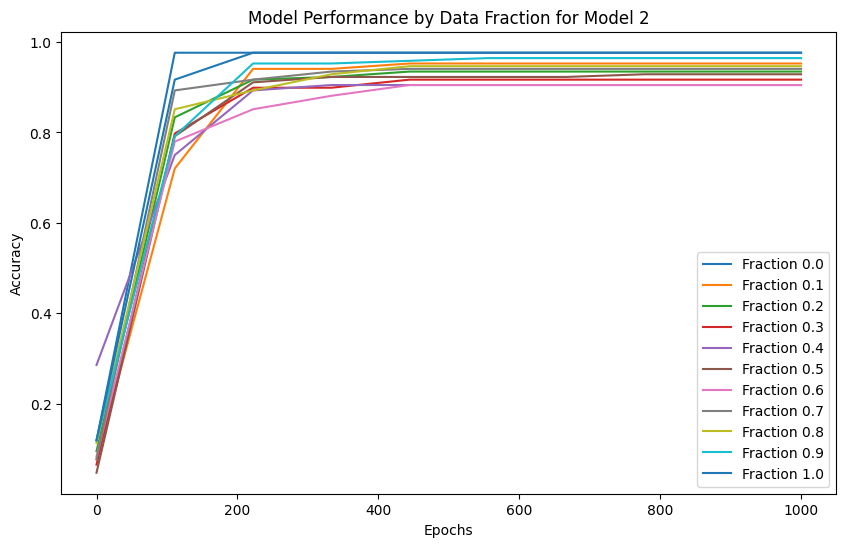

Model 3, Fraction 0.00, Epoch 1, Loss: 2.2176
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 101, Loss: 1.3564
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 201, Loss: 0.5957
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 301, Loss: 0.2777
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 401, Loss: 0.1704
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 501, Loss: 0.1260
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 601, Loss: 0.1038
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 701, Loss: 0.0911
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 801, Loss: 0.0832
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 901, Loss: 0.0780
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.10, Epoch 1, Loss: 2.2022
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.10, Epoch 101, Loss: 1.3200
prediction shape torc

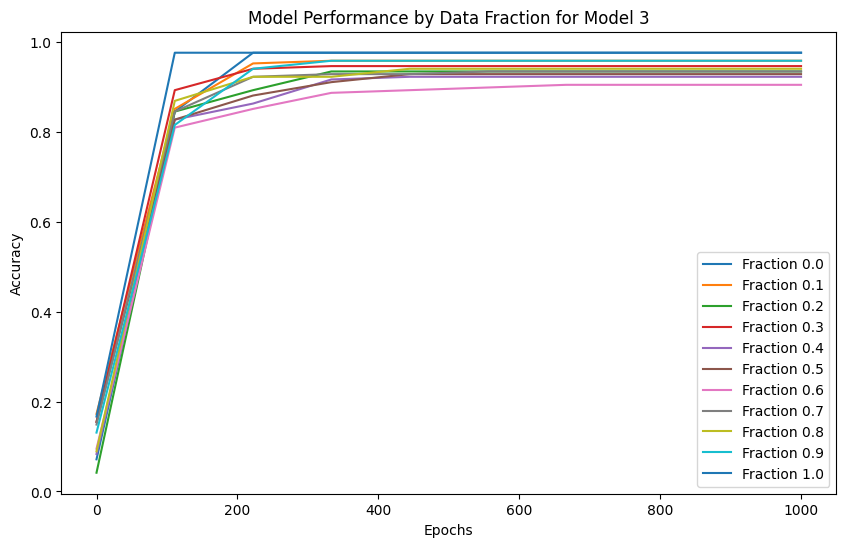

Model 4, Fraction 0.00, Epoch 1, Loss: 2.2125
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 101, Loss: 1.2878
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 201, Loss: 0.5898
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 301, Loss: 0.2889
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 401, Loss: 0.1795
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 501, Loss: 0.1324
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 601, Loss: 0.1083
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 701, Loss: 0.0943
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 801, Loss: 0.0856
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 901, Loss: 0.0797
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.10, Epoch 1, Loss: 2.1930
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.10, Epoch 101, Loss: 1.3147
prediction shape torc

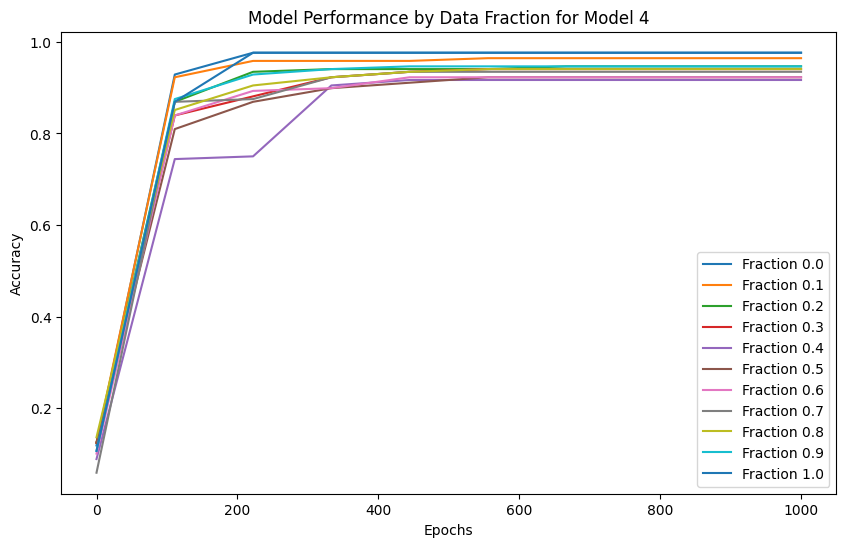

Model 5, Fraction 0.00, Epoch 1, Loss: 2.2181
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 101, Loss: 1.3115
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 201, Loss: 0.6150
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 301, Loss: 0.2895
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 401, Loss: 0.1749
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 501, Loss: 0.1276
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 601, Loss: 0.1044
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 701, Loss: 0.0913
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 801, Loss: 0.0832
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 901, Loss: 0.0779
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.10, Epoch 1, Loss: 2.1887
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.10, Epoch 101, Loss: 1.3466
prediction shape torc

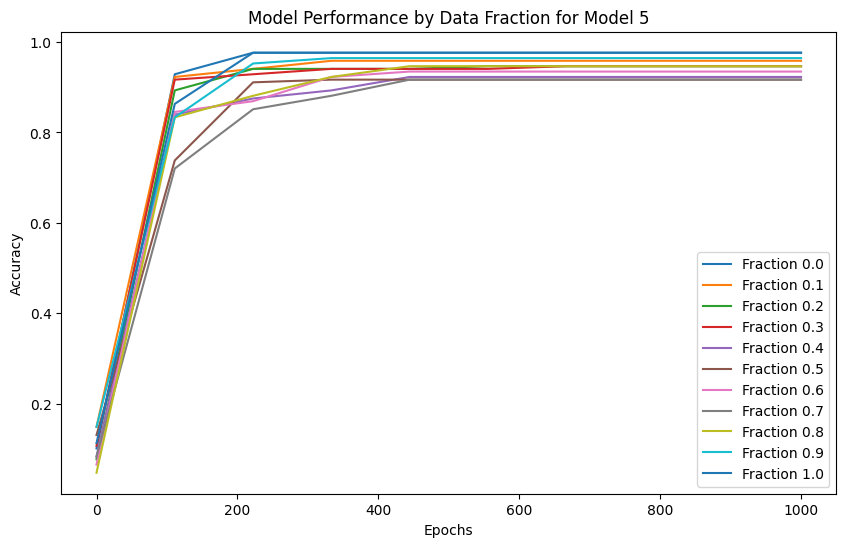

Model 6, Fraction 0.00, Epoch 1, Loss: 2.2045
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 101, Loss: 1.2298
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 201, Loss: 0.5603
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 301, Loss: 0.2911
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 401, Loss: 0.1842
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 501, Loss: 0.1354
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 601, Loss: 0.1101
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 701, Loss: 0.0954
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 801, Loss: 0.0862
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 901, Loss: 0.0801
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.10, Epoch 1, Loss: 2.2141
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.10, Epoch 101, Loss: 1.3368
prediction shape torc

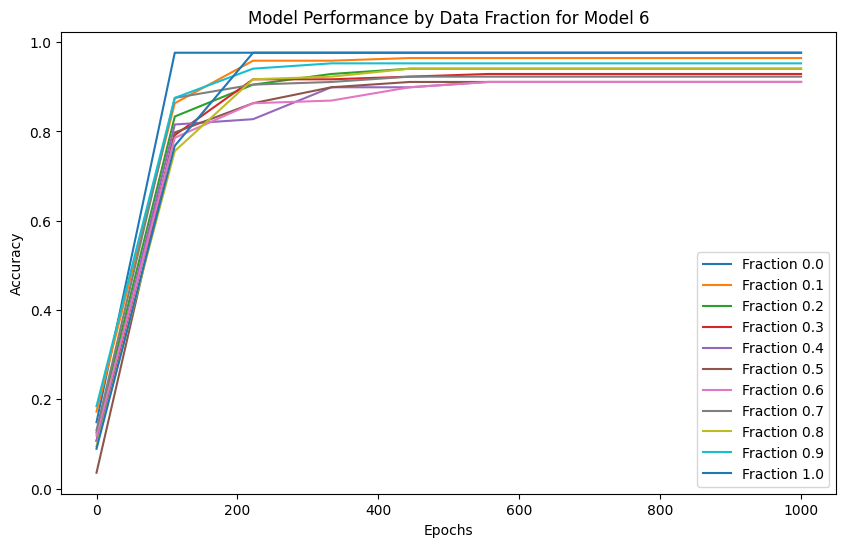

Model 7, Fraction 0.00, Epoch 1, Loss: 2.2091
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 101, Loss: 1.2930
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 201, Loss: 0.5952
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 301, Loss: 0.2904
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 401, Loss: 0.1792
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 501, Loss: 0.1316
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 601, Loss: 0.1074
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 701, Loss: 0.0936
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 801, Loss: 0.0850
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 901, Loss: 0.0793
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.10, Epoch 1, Loss: 2.2326
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.10, Epoch 101, Loss: 1.4320
prediction shape torc

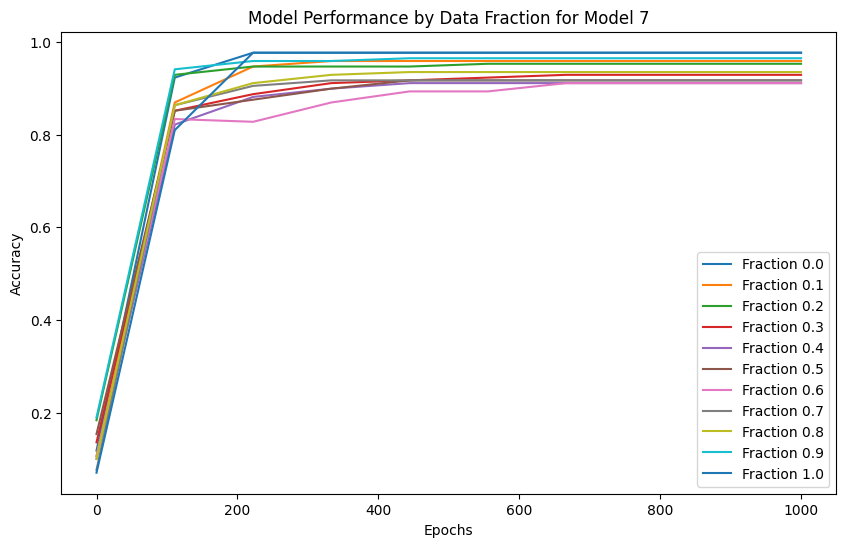

Model 8, Fraction 0.00, Epoch 1, Loss: 2.2061
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 101, Loss: 1.3180
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 201, Loss: 0.5835
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 301, Loss: 0.2837
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 401, Loss: 0.1749
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 501, Loss: 0.1282
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 601, Loss: 0.1047
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 701, Loss: 0.0914
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 801, Loss: 0.0831
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 901, Loss: 0.0776
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.10, Epoch 1, Loss: 2.2037
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.10, Epoch 101, Loss: 1.3080
prediction shape torc

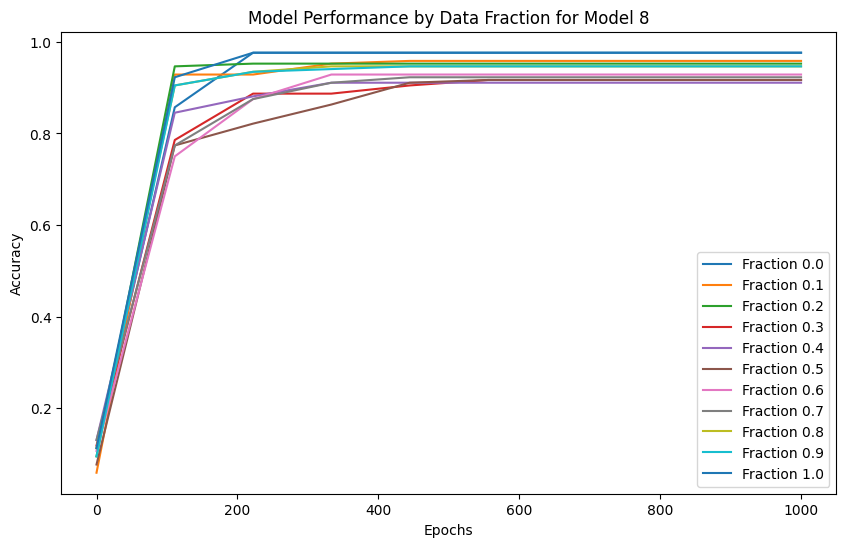

Model 9, Fraction 0.00, Epoch 1, Loss: 2.2176
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 101, Loss: 1.3575
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 201, Loss: 0.6664
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 301, Loss: 0.3152
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 401, Loss: 0.1839
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 501, Loss: 0.1320
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 601, Loss: 0.1070
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 701, Loss: 0.0931
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 801, Loss: 0.0846
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 901, Loss: 0.0789
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.10, Epoch 1, Loss: 2.2147
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.10, Epoch 101, Loss: 1.3622
prediction shape torc

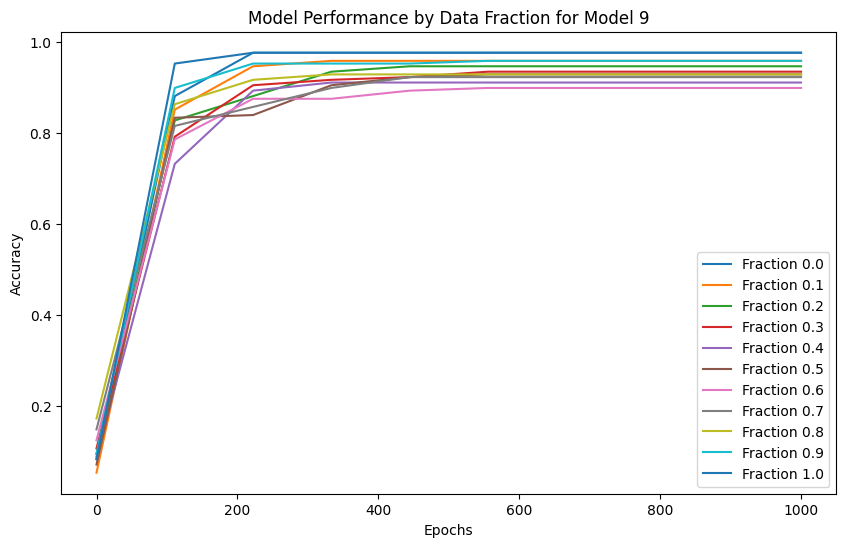

In [62]:
## import os
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt

# Parameters
ntokens = 9
emsize = 8
nhead = 2
d_hid = 8
nlayers = 2
dropout = 0.03
learning_rate = 1e-3
num_epochs = 1000
fractions = np.arange(0, 101, 10) / 100
num_models = 10  # Train 30 different models

songStrings = np.array([
    #"CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC",
    # "ABCDEFGHIABCDEFGHIABCDEFGHIABCDEFGHIABCDEF",
    # "ABCDAFGHIEBCDEAGHIAFCDEFIHIABADEFGCIABCBEF"
    #"AHCFEDGBIAHCFEDGBIAHCFEDGBIAHCFEDGBIAHCFED"
    "ABCDEFGHIABCDEFGHIABCDEFGHIABCDEFGHIABCDEF",
    "ABCDEFIGHABCDEFIGHABCDEFIGHABCDEFIGHABCDEF"
])

for model_idx in range(num_models):
    model_dir = f"Songs_GHI_contradiction_without_new_data/model_{model_idx}"
    os.makedirs(model_dir, exist_ok=True)

    source, target = getTrainingData(songStrings, 2)
    fraction_accuracies = {}

    for fraction in fractions:
        model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)
        W = []
        model.train()
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        input_list, output_list = split_and_shuffle_data_randomly_based_on_fraction(source, target, fraction)

        for epoch in range(num_epochs):
            optimizer.zero_grad()
            source_tensor = torch.tensor(input_list, dtype=torch.long)
            target_tensor = torch.tensor(output_list, dtype=torch.long)

            src = source_tensor.transpose(0, 1)
            tgt = target_tensor.transpose(0, 1)

            output = model(src)
            loss = criterion(output.view(-1, model.ntokens), tgt.reshape(-1))
            loss.backward()
            optimizer.step()

            if epoch % 100 == 0:
                avg_loss = loss.item()
                print(f'Model {model_idx}, Fraction {fraction:.2f}, Epoch {epoch+1}, Loss: {avg_loss:.4f}')
                acc = test(model, source_tensor, target_tensor)
                W.append(acc)
            
            #input_list, output_list = split_and_shuffle_data_randomly_based_on_fraction(source, target, fraction)

        fraction_accuracies[fraction] = W
        model_save_path = os.path.join(model_dir, f'model_at_fraction_{fraction:.2f}.pt')
        torch.save(model.state_dict(), model_save_path)

    # Optionally plot accuracies for each model or save the data for further analysis
    plt.figure(figsize=(10, 6))
    for fraction, accuracies in fraction_accuracies.items():
        epochs = np.linspace(0, num_epochs, len(accuracies))
        plt.plot(epochs, accuracies, label=f'Fraction {fraction}')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Model Performance by Data Fraction for Model {model_idx}')
    plt.legend()
    plt.show()


In [63]:
import os
import numpy as np
import torch

# Assuming TransformerModel and necessary data functions are properly defined
# Initialize the model parameters (keep these consistent with training)
ntokens = 9
emsize = 8
nhead = 2
d_hid = 8
nlayers = 2
dropout = 0.03

# Define the directory where models are saved
base_model_dir = "Songs_GHI_contradiction_without_new_data"

# Fractions and song strings for which models were trained
fractions = np.arange(0, 101, 10) / 100
songStrings = np.array([
    "ABCDEFGHIABCDEFGHIABCDEFGHIABCDEFGHIABCDEF",
    "ABCDEFIGHABCDEFIGHABCDEFIGHABCDEFIGHABCDEF"
])

# Array to store accuracies
accuracies = np.zeros((len(fractions), len(songStrings), num_models))  # Added a dimension for models

# Load and test each model for each fraction and song
for model_idx in range(num_models):  # You trained 10 models
    for frac_idx, fraction in enumerate(fractions):
        for song_idx, song in enumerate(songStrings):
            model_dir = f"{base_model_dir}/model_{model_idx}"
            model_path = os.path.join(model_dir, f'model_at_fraction_{fraction:.2f}.pt')
            
            # Load model if it exists
            if os.path.exists(model_path):
                model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)
                model.load_state_dict(torch.load(model_path))
                model.eval()

                source, target = getTrainingData(np.array([song]), 1)
                source_tensor = torch.tensor(source, dtype=torch.long)
                target_tensor = torch.tensor(target, dtype=torch.long)

                with torch.no_grad():
                    src = source_tensor.transpose(0, 1)
                    tgt = target_tensor.transpose(0, 1)
                    output = model(src)
                    predictions = output.argmax(dim=2)

                    correct = (predictions == tgt).sum().item()
                    total = tgt.numel()

                    accuracy = correct / total
                    accuracies[frac_idx, song_idx, model_idx] = accuracy
            else:
                print(f"Model not found: {model_path}")

# Optionally, average accuracies across all models for each song and fraction
average_accuracies = accuracies.mean(axis=2)  # Average over the model dimension

# Print or process the average accuracies array as needed
for song_idx, song in enumerate(songStrings):
    print(f"Accuracies for Song {song_idx + 1}:")
    for frac_idx, fraction in enumerate(fractions):
        print(f"  Fraction {fraction:.2f}, Average Accuracy: {average_accuracies[frac_idx, song_idx]:.4f}")


Accuracies for Song 1:
  Fraction 0.00, Average Accuracy: 0.6905
  Fraction 0.10, Average Accuracy: 0.7643
  Fraction 0.20, Average Accuracy: 0.7845
  Fraction 0.30, Average Accuracy: 0.8149
  Fraction 0.40, Average Accuracy: 0.8357
  Fraction 0.50, Average Accuracy: 0.8940
  Fraction 0.60, Average Accuracy: 0.9375
  Fraction 0.70, Average Accuracy: 0.9387
  Fraction 0.80, Average Accuracy: 0.9708
  Fraction 0.90, Average Accuracy: 0.9762
  Fraction 1.00, Average Accuracy: 0.9762
Accuracies for Song 2:
  Fraction 0.00, Average Accuracy: 0.9762
  Fraction 0.10, Average Accuracy: 0.9762
  Fraction 0.20, Average Accuracy: 0.9679
  Fraction 0.30, Average Accuracy: 0.9577
  Fraction 0.40, Average Accuracy: 0.9405
  Fraction 0.50, Average Accuracy: 0.8702
  Fraction 0.60, Average Accuracy: 0.8399
  Fraction 0.70, Average Accuracy: 0.8315
  Fraction 0.80, Average Accuracy: 0.7708
  Fraction 0.90, Average Accuracy: 0.7667
  Fraction 1.00, Average Accuracy: 0.6905


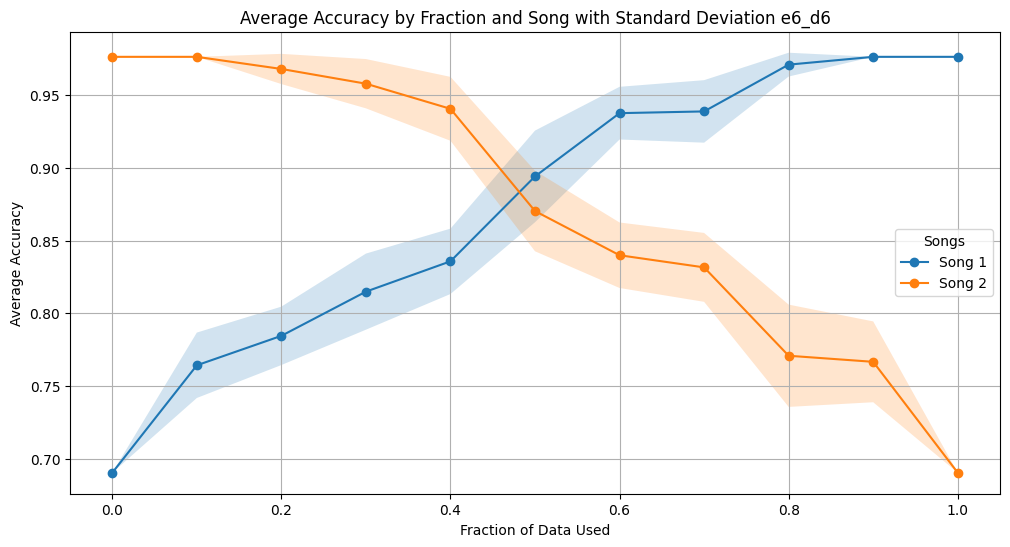

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming accuracies are already calculated and available
# Calculate the average accuracies and standard deviation across all models for each song and fraction
average_accuracies = accuracies.mean(axis=2)  # Average over the model dimension
std_dev_accuracies = accuracies.std(axis=2)  # Standard deviation over the model dimension

# Plotting the accuracies with standard deviation
plt.figure(figsize=(12, 6))
for song_idx, song in enumerate(songStrings):
    # Generate the x-values for the fractions
    x_values = fractions
    y_values = average_accuracies[:, song_idx]
    y_err = std_dev_accuracies[:, song_idx]

    plt.plot(x_values, y_values, marker='o', label=f'Song {song_idx + 1}')
    plt.fill_between(x_values, (y_values - y_err), (y_values + y_err), alpha=0.2)

plt.title('Average Accuracy by Fraction and Song with Standard Deviation e6_d6')
plt.xlabel('Fraction of Data Used')
plt.ylabel('Average Accuracy')
plt.legend(title="Songs")
plt.grid(True)
plt.show()


## Training and Testing for Songs GHI contradiction with new data

Model 0, Fraction 0.00, Epoch 1, Loss: 2.1935
prediction shape torch.Size([4, 42])


/var/folders/wn/f4cc27tx13g8w1qgpzb2bsrm0000gn/T/ipykernel_27373/2366339544.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source = torch.tensor(source, dtype=torch.long)
/var/folders/wn/f4cc27tx13g8w1qgpzb2bsrm0000gn/T/ipykernel_27373/2366339544.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, dtype=torch.long)


Model 0, Fraction 0.00, Epoch 101, Loss: 1.2672
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 201, Loss: 0.6067
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 301, Loss: 0.3061
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 401, Loss: 0.1890
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 501, Loss: 0.1376
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 601, Loss: 0.1113
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 701, Loss: 0.0963
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 801, Loss: 0.0869
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 901, Loss: 0.0807
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.10, Epoch 1, Loss: 2.2194
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.10, Epoch 101, Loss: 1.4098
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.10, Epoch 201, Loss: 0.6757
prediction shape to

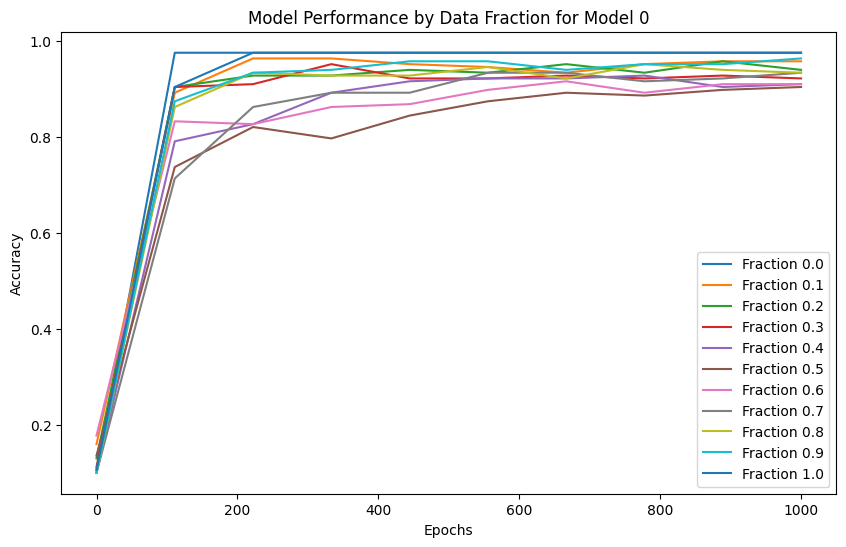

Model 1, Fraction 0.00, Epoch 1, Loss: 2.2167
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 101, Loss: 1.3643
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 201, Loss: 0.6183
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 301, Loss: 0.2966
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 401, Loss: 0.1778
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 501, Loss: 0.1281
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 601, Loss: 0.1041
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 701, Loss: 0.0908
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 801, Loss: 0.0827
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 901, Loss: 0.0773
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.10, Epoch 1, Loss: 2.2077
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.10, Epoch 101, Loss: 1.3519
prediction shape torc

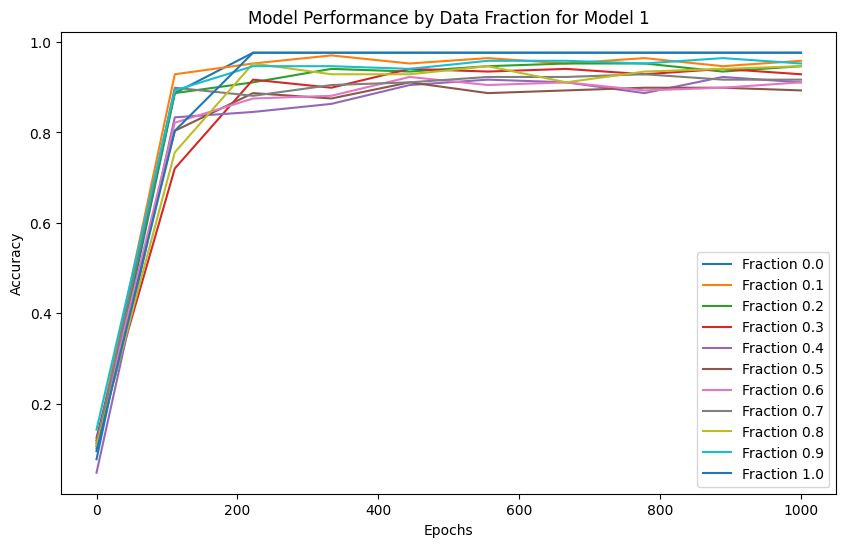

Model 2, Fraction 0.00, Epoch 1, Loss: 2.1985
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 101, Loss: 1.3048
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 201, Loss: 0.5474
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 301, Loss: 0.2520
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 401, Loss: 0.1577
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 501, Loss: 0.1191
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 601, Loss: 0.0997
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 701, Loss: 0.0884
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 801, Loss: 0.0814
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 901, Loss: 0.0766
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.10, Epoch 1, Loss: 2.2073
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.10, Epoch 101, Loss: 1.3036
prediction shape torc

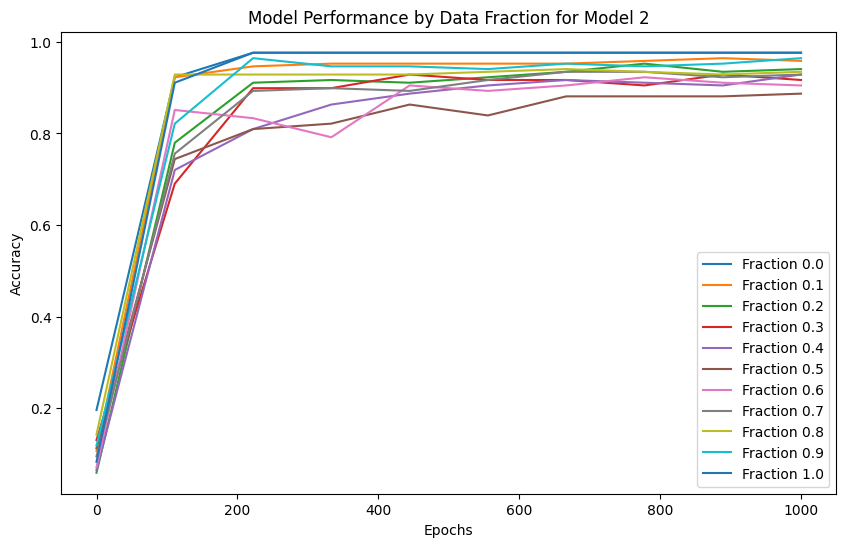

Model 3, Fraction 0.00, Epoch 1, Loss: 2.1868
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 101, Loss: 1.2677
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 201, Loss: 0.5804
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 301, Loss: 0.2755
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 401, Loss: 0.1657
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 501, Loss: 0.1215
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 601, Loss: 0.1000
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 701, Loss: 0.0881
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 801, Loss: 0.0807
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 901, Loss: 0.0759
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.10, Epoch 1, Loss: 2.1946
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.10, Epoch 101, Loss: 1.3355
prediction shape torc

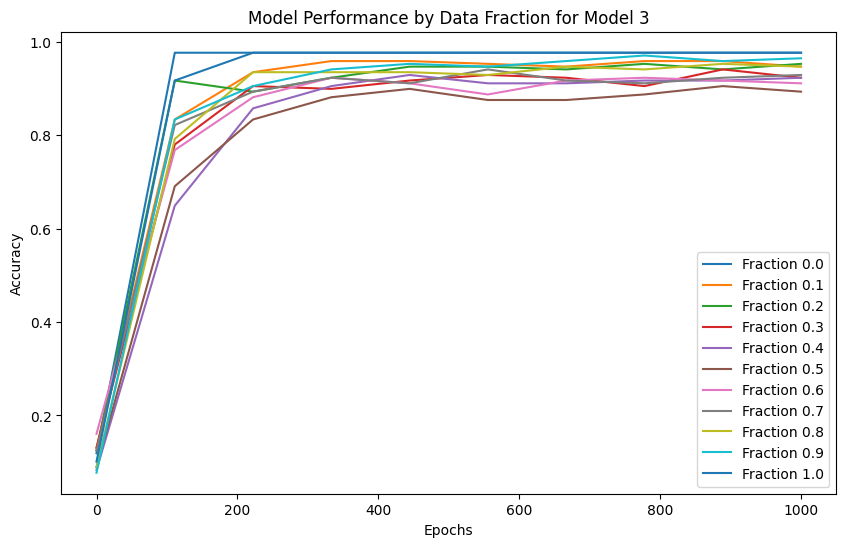

Model 4, Fraction 0.00, Epoch 1, Loss: 2.2292
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 101, Loss: 1.3328
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 201, Loss: 0.6249
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 301, Loss: 0.3080
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 401, Loss: 0.1853
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 501, Loss: 0.1328
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 601, Loss: 0.1071
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 701, Loss: 0.0929
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 801, Loss: 0.0843
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 901, Loss: 0.0786
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.10, Epoch 1, Loss: 2.2016
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.10, Epoch 101, Loss: 1.4595
prediction shape torc

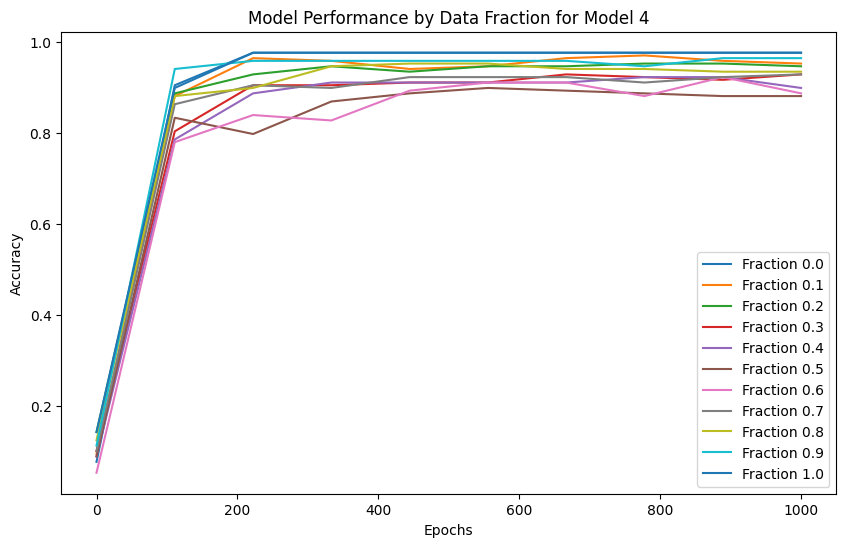

Model 5, Fraction 0.00, Epoch 1, Loss: 2.2142
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 101, Loss: 1.2818
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 201, Loss: 0.5887
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 301, Loss: 0.2943
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 401, Loss: 0.1813
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 501, Loss: 0.1324
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 601, Loss: 0.1077
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 701, Loss: 0.0937
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 801, Loss: 0.0850
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 901, Loss: 0.0792
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.10, Epoch 1, Loss: 2.2230
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.10, Epoch 101, Loss: 1.2968
prediction shape torc

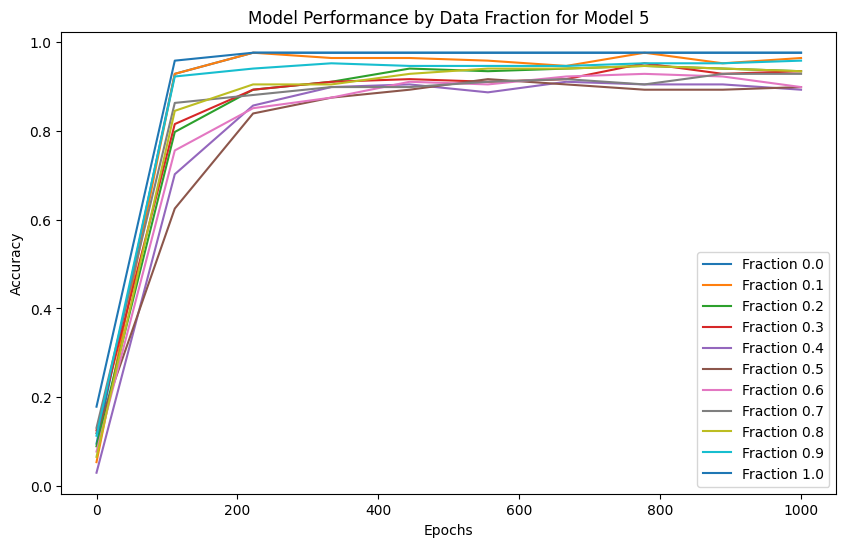

Model 6, Fraction 0.00, Epoch 1, Loss: 2.2002
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 101, Loss: 1.3873
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 201, Loss: 0.6668
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 301, Loss: 0.3175
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 401, Loss: 0.1897
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 501, Loss: 0.1364
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 601, Loss: 0.1099
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 701, Loss: 0.0950
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 801, Loss: 0.0857
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 901, Loss: 0.0797
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.10, Epoch 1, Loss: 2.2027
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.10, Epoch 101, Loss: 1.3756
prediction shape torc

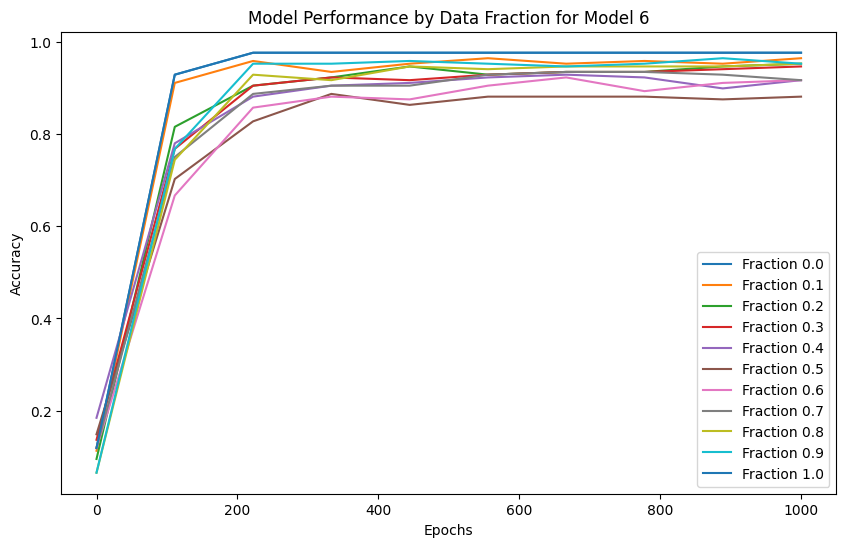

Model 7, Fraction 0.00, Epoch 1, Loss: 2.2195
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 101, Loss: 1.4910
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 201, Loss: 0.6674
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 301, Loss: 0.3136
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 401, Loss: 0.1820
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 501, Loss: 0.1294
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 601, Loss: 0.1043
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 701, Loss: 0.0907
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 801, Loss: 0.0824
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 901, Loss: 0.0770
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.10, Epoch 1, Loss: 2.2352
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.10, Epoch 101, Loss: 1.4432
prediction shape torc

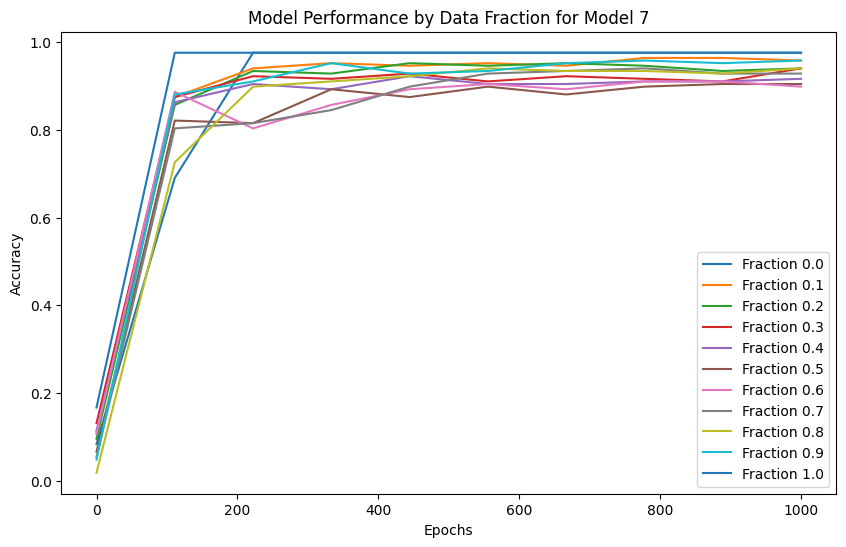

Model 8, Fraction 0.00, Epoch 1, Loss: 2.2235
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 101, Loss: 1.3178
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 201, Loss: 0.6079
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 301, Loss: 0.2916
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 401, Loss: 0.1771
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 501, Loss: 0.1296
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 601, Loss: 0.1060
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 701, Loss: 0.0925
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 801, Loss: 0.0841
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 901, Loss: 0.0786
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.10, Epoch 1, Loss: 2.1970
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.10, Epoch 101, Loss: 1.3491
prediction shape torc

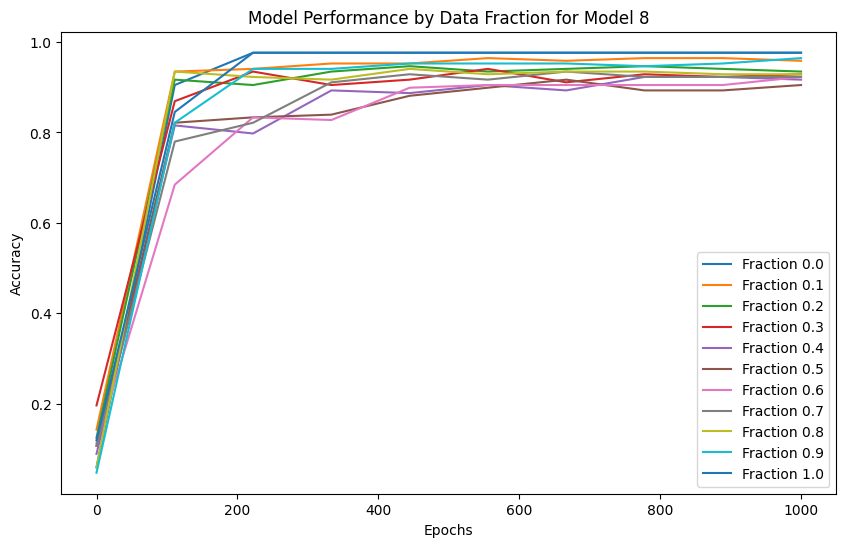

Model 9, Fraction 0.00, Epoch 1, Loss: 2.1907
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 101, Loss: 1.3162
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 201, Loss: 0.6481
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 301, Loss: 0.3102
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 401, Loss: 0.1830
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 501, Loss: 0.1309
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 601, Loss: 0.1058
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 701, Loss: 0.0919
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 801, Loss: 0.0834
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 901, Loss: 0.0779
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.10, Epoch 1, Loss: 2.1959
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.10, Epoch 101, Loss: 1.3151
prediction shape torc

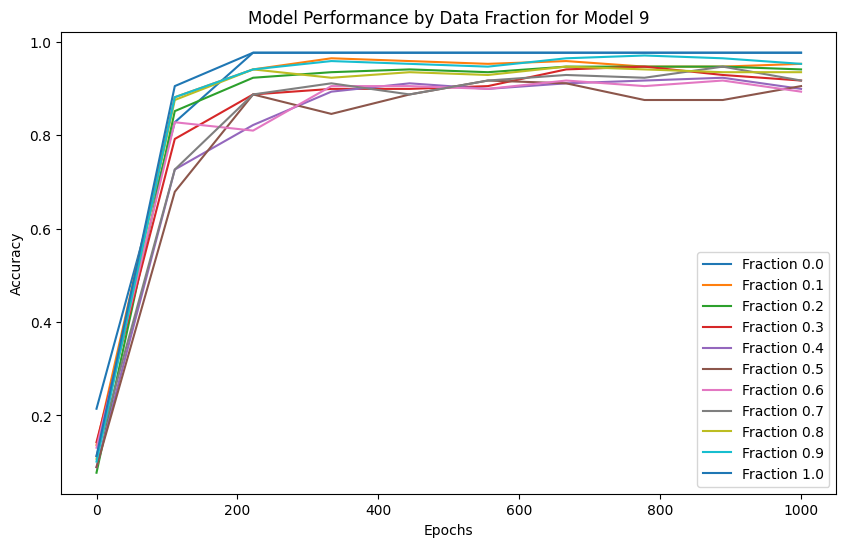

In [65]:
## import os
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt

# Parameters
ntokens = 9
emsize = 8
nhead = 2
d_hid = 8
nlayers = 2
dropout = 0.03
learning_rate = 1e-3
num_epochs = 1000
fractions = np.arange(0, 101, 10) / 100
num_models = 10  # Train 30 different models

songStrings = np.array([
    #"CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC",
    # "ABCDEFGHIABCDEFGHIABCDEFGHIABCDEFGHIABCDEF",
    # "ABCDAFGHIEBCDEAGHIAFCDEFIHIABADEFGCIABCBEF"
    #"AHCFEDGBIAHCFEDGBIAHCFEDGBIAHCFEDGBIAHCFED"
    "ABCDEFGHIABCDEFGHIABCDEFGHIABCDEFGHIABCDEF",
    "ABCDEFIGHABCDEFIGHABCDEFIGHABCDEFIGHABCDEF"
])

for model_idx in range(num_models):
    model_dir = f"Songs_GHI_contradiction_with_new_data/model_{model_idx}"
    os.makedirs(model_dir, exist_ok=True)

    source, target = getTrainingData(songStrings, 2)
    fraction_accuracies = {}

    for fraction in fractions:
        model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)
        W = []
        model.train()
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        input_list, output_list = split_and_shuffle_data_randomly_based_on_fraction(source, target, fraction)

        for epoch in range(num_epochs):
            optimizer.zero_grad()
            source_tensor = torch.tensor(input_list, dtype=torch.long)
            target_tensor = torch.tensor(output_list, dtype=torch.long)

            src = source_tensor.transpose(0, 1)
            tgt = target_tensor.transpose(0, 1)

            output = model(src)
            loss = criterion(output.view(-1, model.ntokens), tgt.reshape(-1))
            loss.backward()
            optimizer.step()

            if epoch % 100 == 0:
                avg_loss = loss.item()
                print(f'Model {model_idx}, Fraction {fraction:.2f}, Epoch {epoch+1}, Loss: {avg_loss:.4f}')
                acc = test(model, source_tensor, target_tensor)
                W.append(acc)
            
            input_list, output_list = split_and_shuffle_data_randomly_based_on_fraction(source, target, fraction)

        fraction_accuracies[fraction] = W
        model_save_path = os.path.join(model_dir, f'model_at_fraction_{fraction:.2f}.pt')
        torch.save(model.state_dict(), model_save_path)

    # Optionally plot accuracies for each model or save the data for further analysis
    plt.figure(figsize=(10, 6))
    for fraction, accuracies in fraction_accuracies.items():
        epochs = np.linspace(0, num_epochs, len(accuracies))
        plt.plot(epochs, accuracies, label=f'Fraction {fraction}')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Model Performance by Data Fraction for Model {model_idx}')
    plt.legend()
    plt.show()


In [66]:
import os
import numpy as np
import torch

# Assuming TransformerModel and necessary data functions are properly defined
# Initialize the model parameters (keep these consistent with training)
ntokens = 9
emsize = 8
nhead = 2
d_hid = 8
nlayers = 2
dropout = 0.03

# Define the directory where models are saved
base_model_dir = "Songs_GHI_contradiction_with_new_data"

# Fractions and song strings for which models were trained
fractions = np.arange(0, 101, 10) / 100
songStrings = np.array([
    "ABCDEFGHIABCDEFGHIABCDEFGHIABCDEFGHIABCDEF",
    "ABCDEFIGHABCDEFIGHABCDEFIGHABCDEFIGHABCDEF"
])

# Array to store accuracies
accuracies = np.zeros((len(fractions), len(songStrings), num_models))  # Added a dimension for models

# Load and test each model for each fraction and song
for model_idx in range(num_models):  # You trained 10 models
    for frac_idx, fraction in enumerate(fractions):
        for song_idx, song in enumerate(songStrings):
            model_dir = f"{base_model_dir}/model_{model_idx}"
            model_path = os.path.join(model_dir, f'model_at_fraction_{fraction:.2f}.pt')
            
            # Load model if it exists
            if os.path.exists(model_path):
                model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)
                model.load_state_dict(torch.load(model_path))
                model.eval()

                source, target = getTrainingData(np.array([song]), 1)
                source_tensor = torch.tensor(source, dtype=torch.long)
                target_tensor = torch.tensor(target, dtype=torch.long)

                with torch.no_grad():
                    src = source_tensor.transpose(0, 1)
                    tgt = target_tensor.transpose(0, 1)
                    output = model(src)
                    predictions = output.argmax(dim=2)

                    correct = (predictions == tgt).sum().item()
                    total = tgt.numel()

                    accuracy = correct / total
                    accuracies[frac_idx, song_idx, model_idx] = accuracy
            else:
                print(f"Model not found: {model_path}")

# Optionally, average accuracies across all models for each song and fraction
average_accuracies = accuracies.mean(axis=2)  # Average over the model dimension

# Print or process the average accuracies array as needed
for song_idx, song in enumerate(songStrings):
    print(f"Accuracies for Song {song_idx + 1}:")
    for frac_idx, fraction in enumerate(fractions):
        print(f"  Fraction {fraction:.2f}, Average Accuracy: {average_accuracies[frac_idx, song_idx]:.4f}")


Accuracies for Song 1:
  Fraction 0.00, Average Accuracy: 0.6905
  Fraction 0.10, Average Accuracy: 0.8048
  Fraction 0.20, Average Accuracy: 0.8095
  Fraction 0.30, Average Accuracy: 0.8143
  Fraction 0.40, Average Accuracy: 0.8143
  Fraction 0.50, Average Accuracy: 0.8881
  Fraction 0.60, Average Accuracy: 0.9667
  Fraction 0.70, Average Accuracy: 0.9762
  Fraction 0.80, Average Accuracy: 0.9762
  Fraction 0.90, Average Accuracy: 0.9762
  Fraction 1.00, Average Accuracy: 0.9762
Accuracies for Song 2:
  Fraction 0.00, Average Accuracy: 0.9762
  Fraction 0.10, Average Accuracy: 0.9762
  Fraction 0.20, Average Accuracy: 0.9762
  Fraction 0.30, Average Accuracy: 0.9714
  Fraction 0.40, Average Accuracy: 0.9714
  Fraction 0.50, Average Accuracy: 0.8976
  Fraction 0.60, Average Accuracy: 0.8190
  Fraction 0.70, Average Accuracy: 0.8095
  Fraction 0.80, Average Accuracy: 0.8095
  Fraction 0.90, Average Accuracy: 0.8095
  Fraction 1.00, Average Accuracy: 0.6905


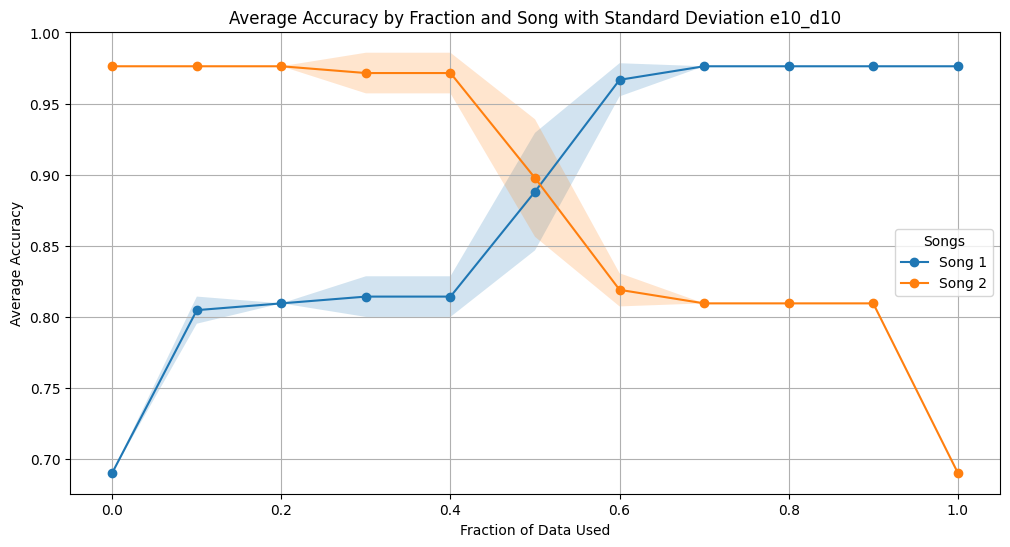

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming accuracies are already calculated and available
# Calculate the average accuracies and standard deviation across all models for each song and fraction
average_accuracies = accuracies.mean(axis=2)  # Average over the model dimension
std_dev_accuracies = accuracies.std(axis=2)  # Standard deviation over the model dimension

# Plotting the accuracies with standard deviation
plt.figure(figsize=(12, 6))
for song_idx, song in enumerate(songStrings):
    # Generate the x-values for the fractions
    x_values = fractions
    y_values = average_accuracies[:, song_idx]
    y_err = std_dev_accuracies[:, song_idx]

    plt.plot(x_values, y_values, marker='o', label=f'Song {song_idx + 1}')
    plt.fill_between(x_values, (y_values - y_err), (y_values + y_err), alpha=0.2)

plt.title('Average Accuracy by Fraction and Song with Standard Deviation e10_d10')
plt.xlabel('Fraction of Data Used')
plt.ylabel('Average Accuracy')
plt.legend(title="Songs")
plt.grid(True)
plt.show()


## Training and Testing for Different songsSongs 

Model 0, Fraction 0.00, Epoch 1, Loss: 2.2045
prediction shape torch.Size([4, 42])


/var/folders/wn/f4cc27tx13g8w1qgpzb2bsrm0000gn/T/ipykernel_27373/2366339544.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source = torch.tensor(source, dtype=torch.long)
/var/folders/wn/f4cc27tx13g8w1qgpzb2bsrm0000gn/T/ipykernel_27373/2366339544.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, dtype=torch.long)


Model 0, Fraction 0.00, Epoch 101, Loss: 1.3345
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 201, Loss: 0.5874
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 301, Loss: 0.2762
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 401, Loss: 0.1721
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 501, Loss: 0.1281
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 601, Loss: 0.1054
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 701, Loss: 0.0923
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 801, Loss: 0.0840
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 901, Loss: 0.0784
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.10, Epoch 1, Loss: 2.2330
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.10, Epoch 101, Loss: 1.5648
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.10, Epoch 201, Loss: 0.8523
prediction shape to

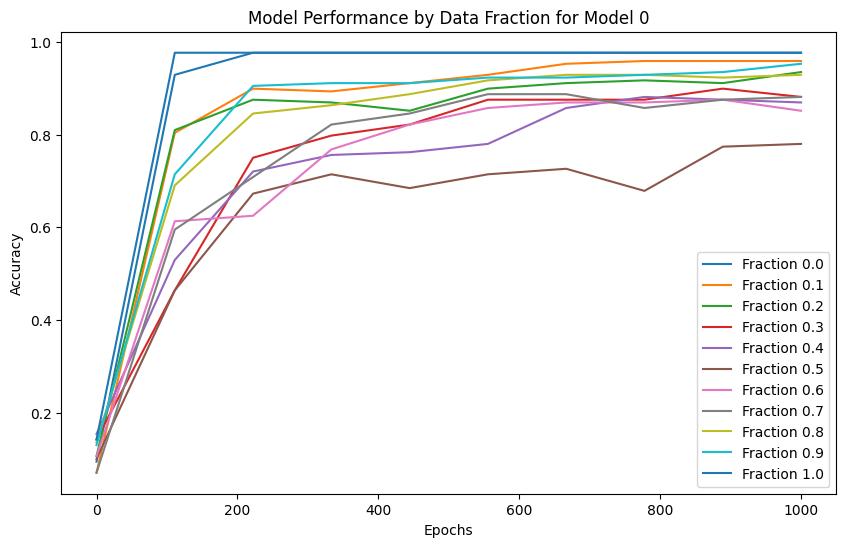

Model 1, Fraction 0.00, Epoch 1, Loss: 2.2267
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 101, Loss: 1.3490
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 201, Loss: 0.6421
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 301, Loss: 0.2981
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 401, Loss: 0.1771
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 501, Loss: 0.1287
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 601, Loss: 0.1051
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 701, Loss: 0.0919
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 801, Loss: 0.0837
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 901, Loss: 0.0783
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.10, Epoch 1, Loss: 2.2064
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.10, Epoch 101, Loss: 1.4551
prediction shape torc

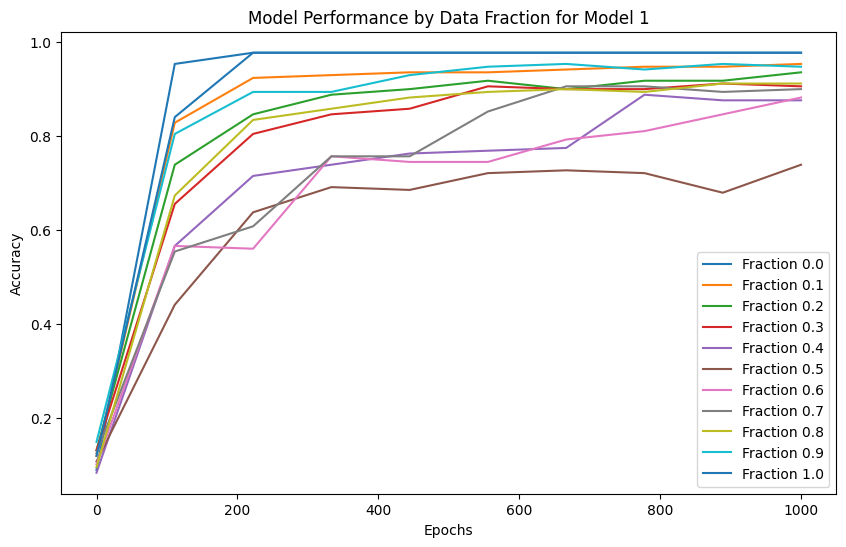

Model 2, Fraction 0.00, Epoch 1, Loss: 2.1913
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 101, Loss: 1.2542
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 201, Loss: 0.5371
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 301, Loss: 0.2698
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 401, Loss: 0.1707
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 501, Loss: 0.1273
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 601, Loss: 0.1050
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 701, Loss: 0.0922
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 801, Loss: 0.0841
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 901, Loss: 0.0786
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.10, Epoch 1, Loss: 2.1934
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.10, Epoch 101, Loss: 1.4140
prediction shape torc

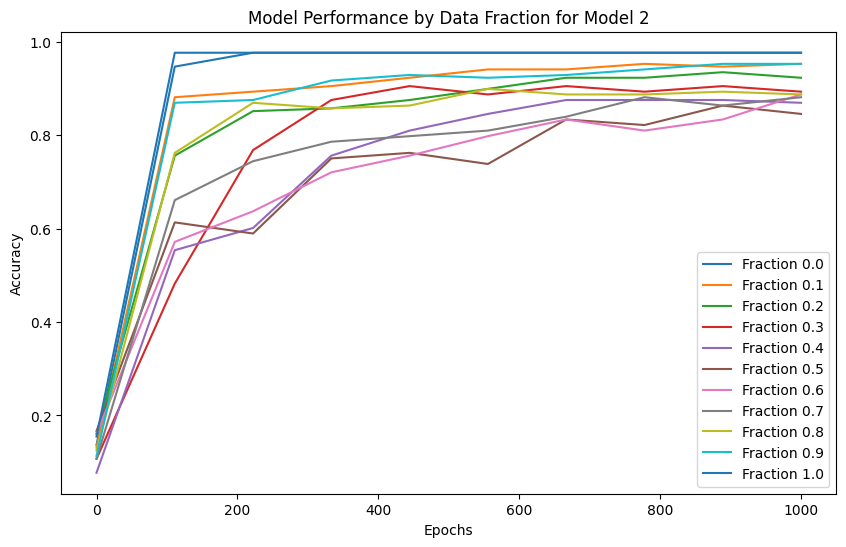

Model 3, Fraction 0.00, Epoch 1, Loss: 2.2066
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 101, Loss: 1.2895
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 201, Loss: 0.5902
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 301, Loss: 0.2849
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 401, Loss: 0.1740
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 501, Loss: 0.1277
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 601, Loss: 0.1047
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 701, Loss: 0.0916
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 801, Loss: 0.0835
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 901, Loss: 0.0781
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.10, Epoch 1, Loss: 2.2133
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.10, Epoch 101, Loss: 1.3980
prediction shape torc

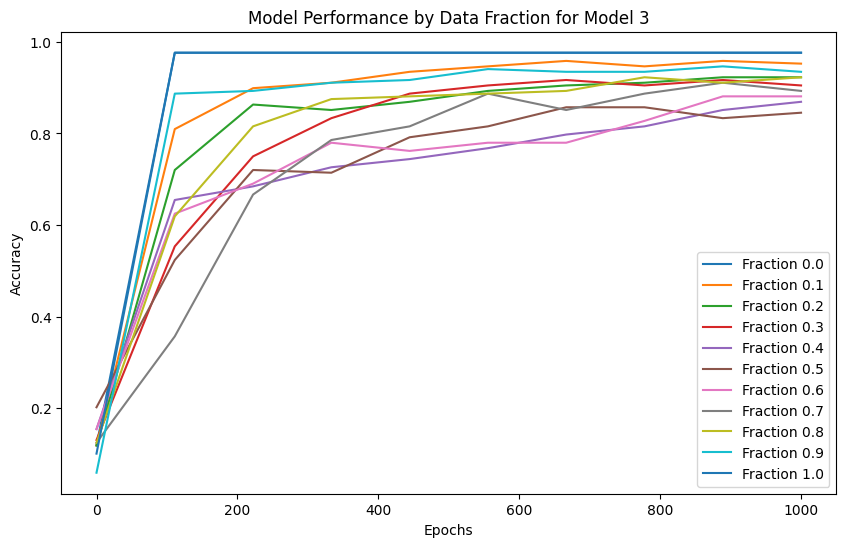

Model 4, Fraction 0.00, Epoch 1, Loss: 2.2150
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 101, Loss: 1.3679
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 201, Loss: 0.6933
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 301, Loss: 0.3233
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 401, Loss: 0.1884
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 501, Loss: 0.1345
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 601, Loss: 0.1084
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 701, Loss: 0.0939
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 801, Loss: 0.0851
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 901, Loss: 0.0792
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.10, Epoch 1, Loss: 2.2325
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.10, Epoch 101, Loss: 1.4256
prediction shape torc

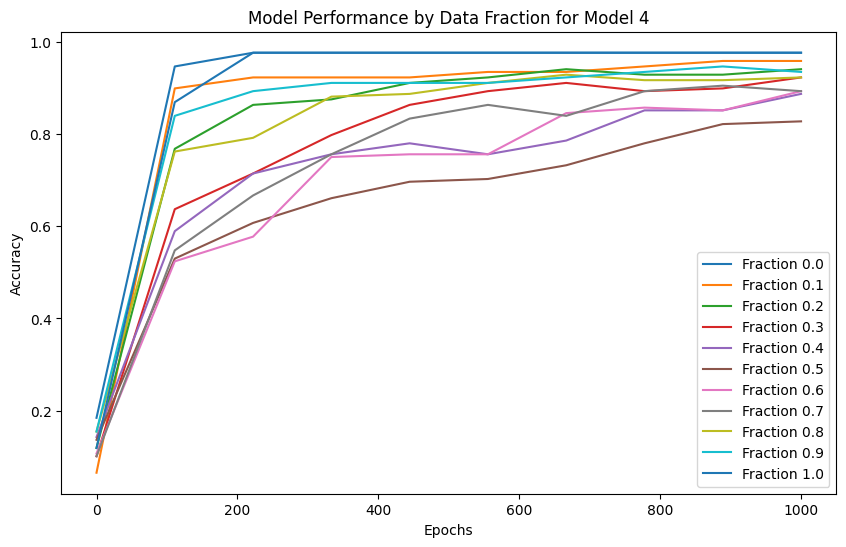

Model 5, Fraction 0.00, Epoch 1, Loss: 2.2056
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 101, Loss: 1.2871
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 201, Loss: 0.5879
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 301, Loss: 0.2932
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 401, Loss: 0.1825
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 501, Loss: 0.1342
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 601, Loss: 0.1095
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 701, Loss: 0.0952
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 801, Loss: 0.0863
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 901, Loss: 0.0803
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.10, Epoch 1, Loss: 2.1999
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.10, Epoch 101, Loss: 1.3672
prediction shape torc

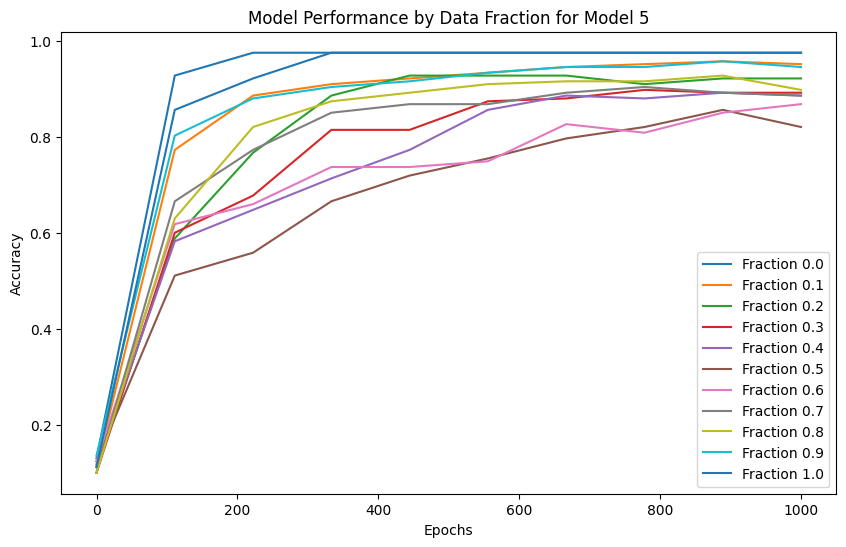

Model 6, Fraction 0.00, Epoch 1, Loss: 2.2187
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 101, Loss: 1.3085
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 201, Loss: 0.6036
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 301, Loss: 0.2925
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 401, Loss: 0.1795
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 501, Loss: 0.1315
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 601, Loss: 0.1073
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 701, Loss: 0.0935
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 801, Loss: 0.0850
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 901, Loss: 0.0792
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.10, Epoch 1, Loss: 2.2099
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.10, Epoch 101, Loss: 1.4105
prediction shape torc

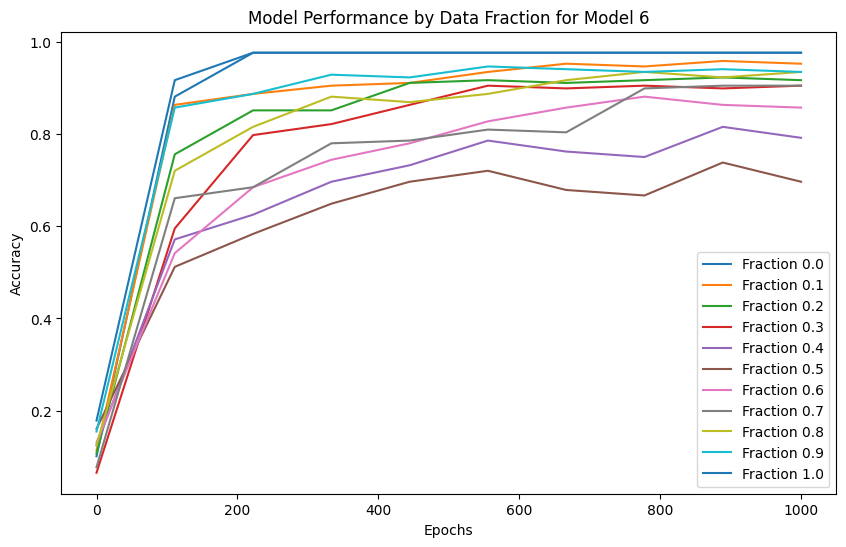

Model 7, Fraction 0.00, Epoch 1, Loss: 2.2183
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 101, Loss: 1.2739
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 201, Loss: 0.6106
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 301, Loss: 0.3049
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 401, Loss: 0.1845
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 501, Loss: 0.1329
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 601, Loss: 0.1075
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 701, Loss: 0.0932
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 801, Loss: 0.0845
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 901, Loss: 0.0788
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.10, Epoch 1, Loss: 2.2188
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.10, Epoch 101, Loss: 1.5105
prediction shape torc

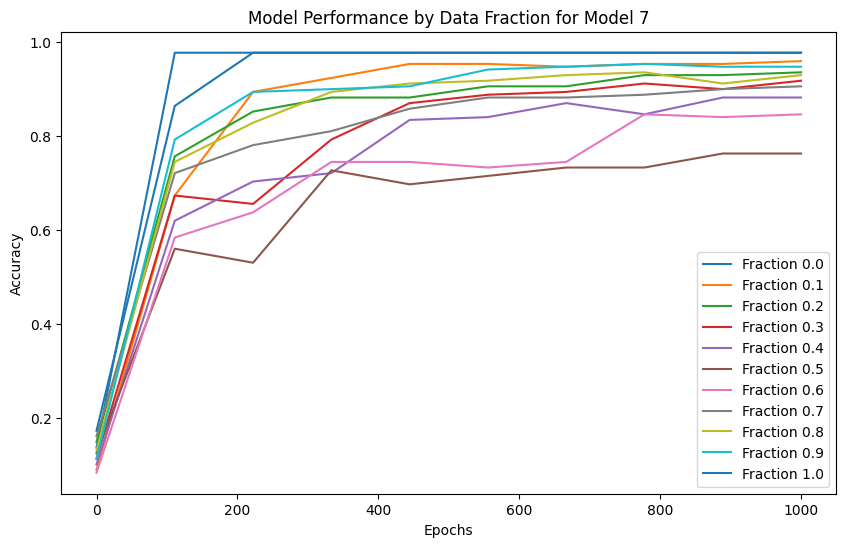

Model 8, Fraction 0.00, Epoch 1, Loss: 2.1882
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 101, Loss: 1.2262
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 201, Loss: 0.5751
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 301, Loss: 0.2901
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 401, Loss: 0.1797
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 501, Loss: 0.1318
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 601, Loss: 0.1075
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 701, Loss: 0.0937
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 801, Loss: 0.0851
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 901, Loss: 0.0793
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.10, Epoch 1, Loss: 2.2103
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.10, Epoch 101, Loss: 1.4596
prediction shape torc

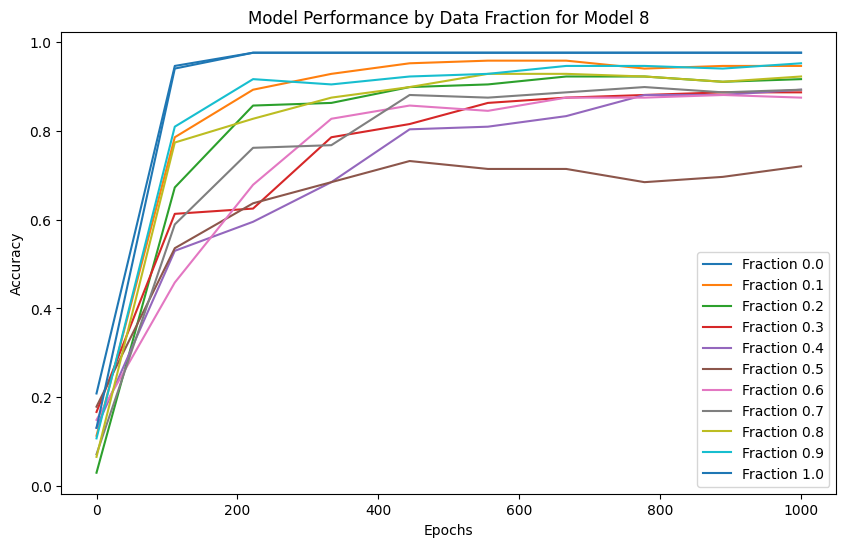

Model 9, Fraction 0.00, Epoch 1, Loss: 2.2006
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 101, Loss: 1.2804
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 201, Loss: 0.5873
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 301, Loss: 0.2886
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 401, Loss: 0.1767
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 501, Loss: 0.1292
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 601, Loss: 0.1056
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 701, Loss: 0.0922
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 801, Loss: 0.0840
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 901, Loss: 0.0785
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.10, Epoch 1, Loss: 2.1931
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.10, Epoch 101, Loss: 1.4187
prediction shape torc

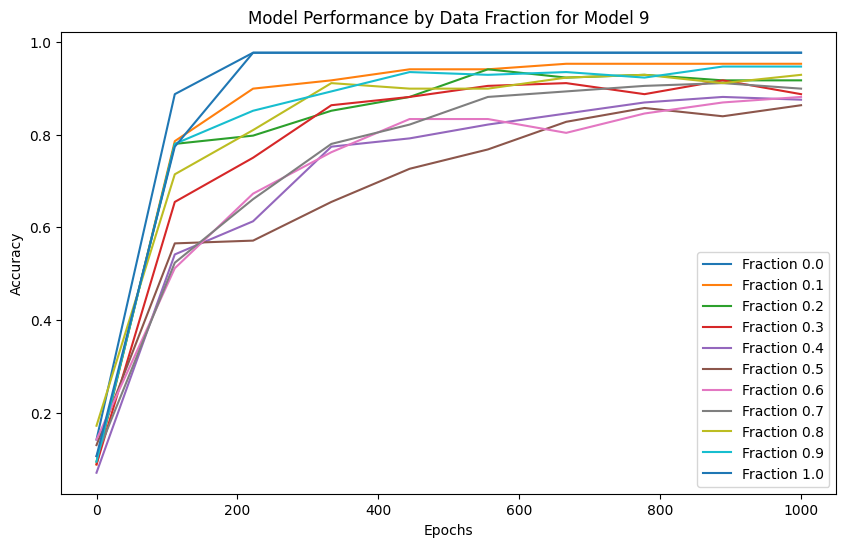

In [68]:
## import os
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt

# Parameters
ntokens = 9
emsize = 8
nhead = 2
d_hid = 8
nlayers = 2
dropout = 0.03
learning_rate = 1e-3
num_epochs = 1000
fractions = np.arange(0, 101, 10) / 100
num_models = 10  # Train 30 different models

songStrings = np.array([
    #"CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC",
    # "ABCDEFGHIABCDEFGHIABCDEFGHIABCDEFGHIABCDEF",
    # "ABCDAFGHIEBCDEAGHIAFCDEFIHIABADEFGCIABCBEF"
    "AHCFEDGBIAHCFEDGBIAHCFEDGBIAHCFEDGBIAHCFED",
    "ABCDEFGHIABCDEFGHIABCDEFGHIABCDEFGHIABCDEF"
    #"ABCDEFIGHABCDEFIGHABCDEFIGHABCDEFIGHABCDEF"
])

for model_idx in range(num_models):
    model_dir = f"Songs_different/model_{model_idx}"
    os.makedirs(model_dir, exist_ok=True)

    source, target = getTrainingData(songStrings, 2)
    fraction_accuracies = {}

    for fraction in fractions:
        model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)
        W = []
        model.train()
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        input_list, output_list = split_and_shuffle_data_randomly_based_on_fraction(source, target, fraction)

        for epoch in range(num_epochs):
            optimizer.zero_grad()
            source_tensor = torch.tensor(input_list, dtype=torch.long)
            target_tensor = torch.tensor(output_list, dtype=torch.long)

            src = source_tensor.transpose(0, 1)
            tgt = target_tensor.transpose(0, 1)

            output = model(src)
            loss = criterion(output.view(-1, model.ntokens), tgt.reshape(-1))
            loss.backward()
            optimizer.step()

            if epoch % 100 == 0:
                avg_loss = loss.item()
                print(f'Model {model_idx}, Fraction {fraction:.2f}, Epoch {epoch+1}, Loss: {avg_loss:.4f}')
                acc = test(model, source_tensor, target_tensor)
                W.append(acc)
            
            input_list, output_list = split_and_shuffle_data_randomly_based_on_fraction(source, target, fraction)

        fraction_accuracies[fraction] = W
        model_save_path = os.path.join(model_dir, f'model_at_fraction_{fraction:.2f}.pt')
        torch.save(model.state_dict(), model_save_path)

    # Optionally plot accuracies for each model or save the data for further analysis
    plt.figure(figsize=(10, 6))
    for fraction, accuracies in fraction_accuracies.items():
        epochs = np.linspace(0, num_epochs, len(accuracies))
        plt.plot(epochs, accuracies, label=f'Fraction {fraction}')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Model Performance by Data Fraction for Model {model_idx}')
    plt.legend()
    plt.show()


In [69]:
import os
import numpy as np
import torch

# Assuming TransformerModel and necessary data functions are properly defined
# Initialize the model parameters (keep these consistent with training)
ntokens = 9
emsize = 8
nhead = 2
d_hid = 8
nlayers = 2
dropout = 0.03

# Define the directory where models are saved
base_model_dir = "Songs_different"

# Fractions and song strings for which models were trained
fractions = np.arange(0, 101, 10) / 100
songStrings = np.array([
    "AHCFEDGBIAHCFEDGBIAHCFEDGBIAHCFEDGBIAHCFED",
    "ABCDEFGHIABCDEFGHIABCDEFGHIABCDEFGHIABCDEF"
])

# Array to store accuracies
accuracies = np.zeros((len(fractions), len(songStrings), num_models))  # Added a dimension for models

# Load and test each model for each fraction and song
for model_idx in range(num_models):  # You trained 10 models
    for frac_idx, fraction in enumerate(fractions):
        for song_idx, song in enumerate(songStrings):
            model_dir = f"{base_model_dir}/model_{model_idx}"
            model_path = os.path.join(model_dir, f'model_at_fraction_{fraction:.2f}.pt')
            
            # Load model if it exists
            if os.path.exists(model_path):
                model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)
                model.load_state_dict(torch.load(model_path))
                model.eval()

                source, target = getTrainingData(np.array([song]), 1)
                source_tensor = torch.tensor(source, dtype=torch.long)
                target_tensor = torch.tensor(target, dtype=torch.long)

                with torch.no_grad():
                    src = source_tensor.transpose(0, 1)
                    tgt = target_tensor.transpose(0, 1)
                    output = model(src)
                    predictions = output.argmax(dim=2)

                    correct = (predictions == tgt).sum().item()
                    total = tgt.numel()

                    accuracy = correct / total
                    accuracies[frac_idx, song_idx, model_idx] = accuracy
            else:
                print(f"Model not found: {model_path}")

# Optionally, average accuracies across all models for each song and fraction
average_accuracies = accuracies.mean(axis=2)  # Average over the model dimension

# Print or process the average accuracies array as needed
for song_idx, song in enumerate(songStrings):
    print(f"Accuracies for Song {song_idx + 1}:")
    for frac_idx, fraction in enumerate(fractions):
        print(f"  Fraction {fraction:.2f}, Average Accuracy: {average_accuracies[frac_idx, song_idx]:.4f}")


Accuracies for Song 1:
  Fraction 0.00, Average Accuracy: 0.0952
  Fraction 0.10, Average Accuracy: 0.7274
  Fraction 0.20, Average Accuracy: 0.7238
  Fraction 0.30, Average Accuracy: 0.7190
  Fraction 0.40, Average Accuracy: 0.7518
  Fraction 0.50, Average Accuracy: 0.8274
  Fraction 0.60, Average Accuracy: 0.9506
  Fraction 0.70, Average Accuracy: 0.9661
  Fraction 0.80, Average Accuracy: 0.9762
  Fraction 0.90, Average Accuracy: 0.9762
  Fraction 1.00, Average Accuracy: 0.9762
Accuracies for Song 2:
  Fraction 0.00, Average Accuracy: 0.9762
  Fraction 0.10, Average Accuracy: 0.9762
  Fraction 0.20, Average Accuracy: 0.9762
  Fraction 0.30, Average Accuracy: 0.9762
  Fraction 0.40, Average Accuracy: 0.9500
  Fraction 0.50, Average Accuracy: 0.7845
  Fraction 0.60, Average Accuracy: 0.7512
  Fraction 0.70, Average Accuracy: 0.7345
  Fraction 0.80, Average Accuracy: 0.7155
  Fraction 0.90, Average Accuracy: 0.7167
  Fraction 1.00, Average Accuracy: 0.0976


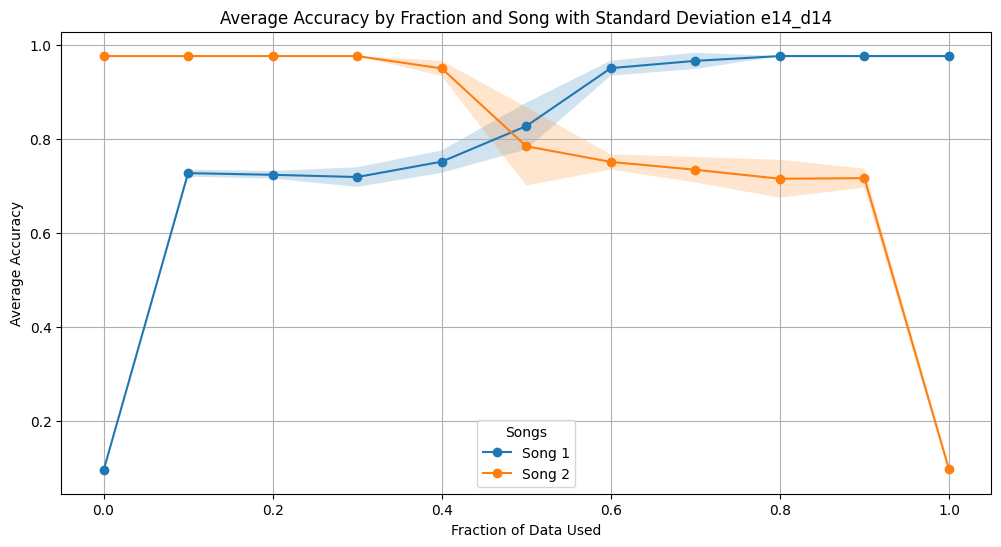

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming accuracies are already calculated and available
# Calculate the average accuracies and standard deviation across all models for each song and fraction
average_accuracies = accuracies.mean(axis=2)  # Average over the model dimension
std_dev_accuracies = accuracies.std(axis=2)  # Standard deviation over the model dimension

# Plotting the accuracies with standard deviation
plt.figure(figsize=(12, 6))
for song_idx, song in enumerate(songStrings):
    # Generate the x-values for the fractions
    x_values = fractions
    y_values = average_accuracies[:, song_idx]
    y_err = std_dev_accuracies[:, song_idx]

    plt.plot(x_values, y_values, marker='o', label=f'Song {song_idx + 1}')
    plt.fill_between(x_values, (y_values - y_err), (y_values + y_err), alpha=0.2)

plt.title('Average Accuracy by Fraction and Song with Standard Deviation e14_d14')
plt.xlabel('Fraction of Data Used')
plt.ylabel('Average Accuracy')
plt.legend(title="Songs")
plt.grid(True)
plt.show()


## training and testing for lower parameters

Model 0, Fraction 0.00, Epoch 1, Loss: 2.2056
prediction shape torch.Size([4, 42])


/var/folders/wn/f4cc27tx13g8w1qgpzb2bsrm0000gn/T/ipykernel_27373/2366339544.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source = torch.tensor(source, dtype=torch.long)
/var/folders/wn/f4cc27tx13g8w1qgpzb2bsrm0000gn/T/ipykernel_27373/2366339544.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, dtype=torch.long)


Model 0, Fraction 0.00, Epoch 101, Loss: 1.9635
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 201, Loss: 1.5493
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 301, Loss: 1.2935
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 401, Loss: 1.0077
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 501, Loss: 0.7326
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 601, Loss: 0.5290
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 701, Loss: 0.4032
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 801, Loss: 0.2773
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 901, Loss: 0.2078
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.10, Epoch 1, Loss: 2.2081
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.10, Epoch 101, Loss: 1.9308
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.10, Epoch 201, Loss: 1.5669
prediction shape to

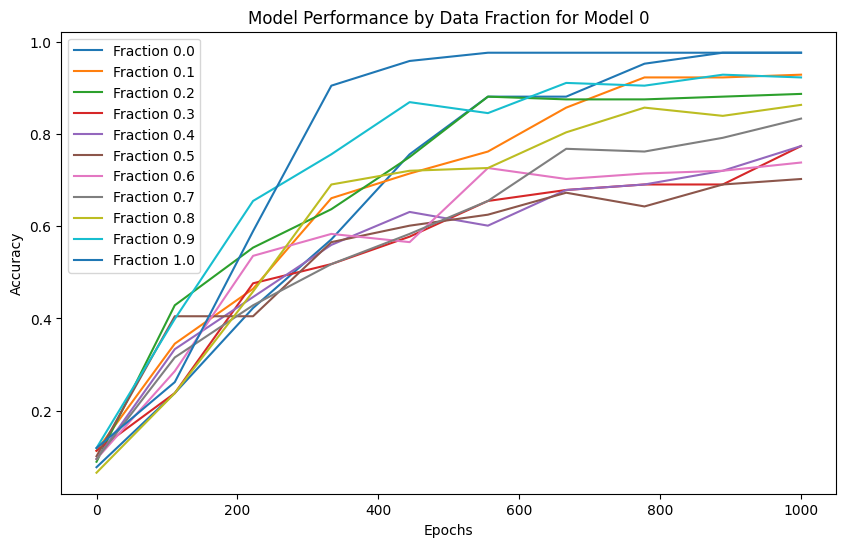

Model 1, Fraction 0.00, Epoch 1, Loss: 2.2068
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 101, Loss: 1.9279
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 201, Loss: 1.3756
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 301, Loss: 1.0497
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 401, Loss: 0.7794
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 501, Loss: 0.5338
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 601, Loss: 0.3616
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 701, Loss: 0.2665
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 801, Loss: 0.2074
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 901, Loss: 0.1691
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.10, Epoch 1, Loss: 2.1991
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.10, Epoch 101, Loss: 1.8781
prediction shape torc

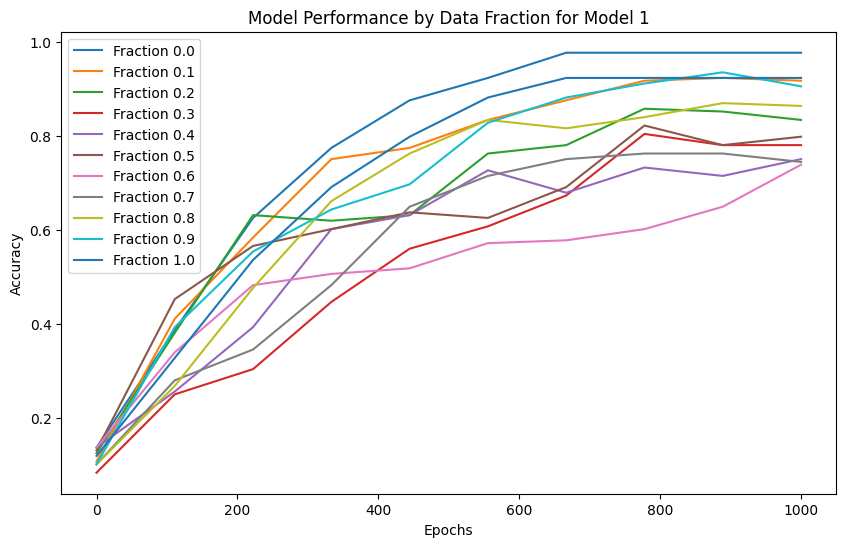

Model 2, Fraction 0.00, Epoch 1, Loss: 2.1956
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 101, Loss: 1.8786
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 201, Loss: 1.3229
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 301, Loss: 0.9927
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 401, Loss: 0.7549
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 501, Loss: 0.5772
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 601, Loss: 0.4213
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 701, Loss: 0.3019
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 801, Loss: 0.2201
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 901, Loss: 0.1744
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.10, Epoch 1, Loss: 2.1938
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.10, Epoch 101, Loss: 1.9936
prediction shape torc

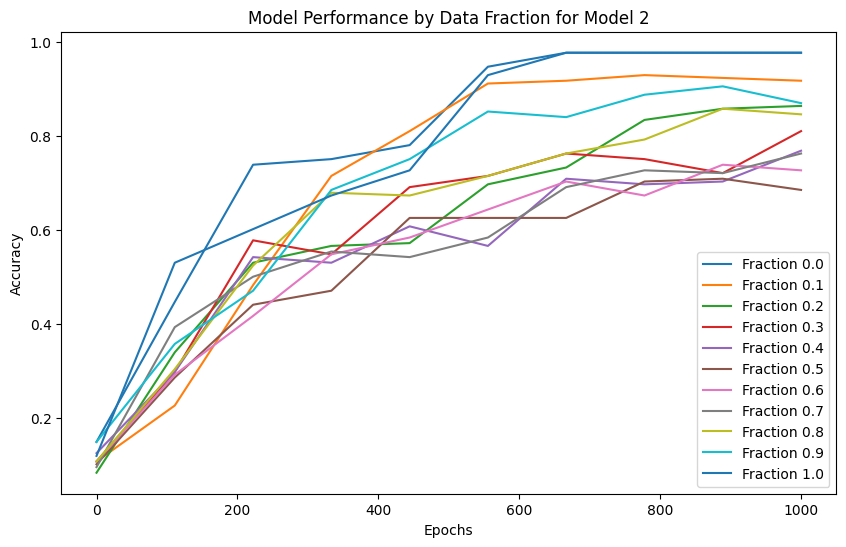

Model 3, Fraction 0.00, Epoch 1, Loss: 2.2007
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 101, Loss: 1.8200
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 201, Loss: 1.3795
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 301, Loss: 1.1296
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 401, Loss: 0.8970
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 501, Loss: 0.6573
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 601, Loss: 0.4870
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 701, Loss: 0.3331
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 801, Loss: 0.2395
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 901, Loss: 0.1886
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.10, Epoch 1, Loss: 2.2121
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.10, Epoch 101, Loss: 2.0615
prediction shape torc

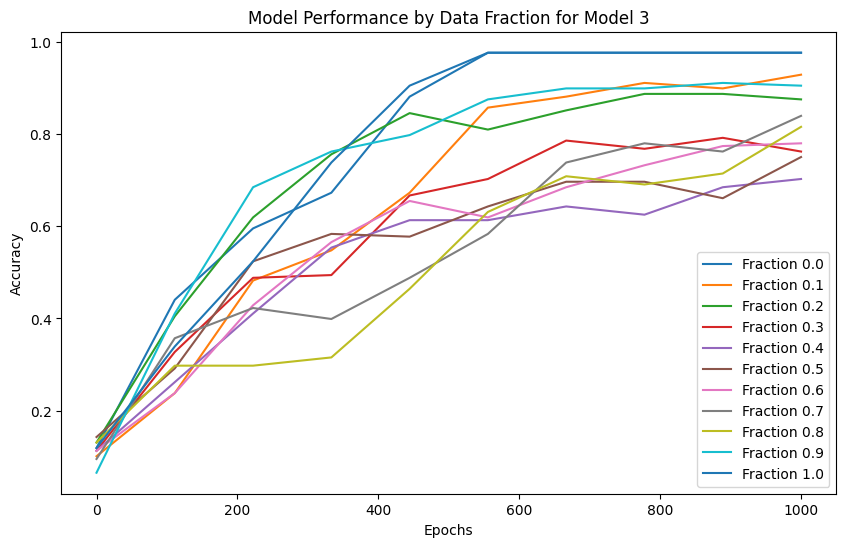

Model 4, Fraction 0.00, Epoch 1, Loss: 2.1974
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 101, Loss: 1.8641
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 201, Loss: 1.3023
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 301, Loss: 0.9050
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 401, Loss: 0.6571
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 501, Loss: 0.4852
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 601, Loss: 0.3751
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 701, Loss: 0.3089
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 801, Loss: 0.2623
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 901, Loss: 0.2128
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.10, Epoch 1, Loss: 2.2103
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.10, Epoch 101, Loss: 1.9897
prediction shape torc

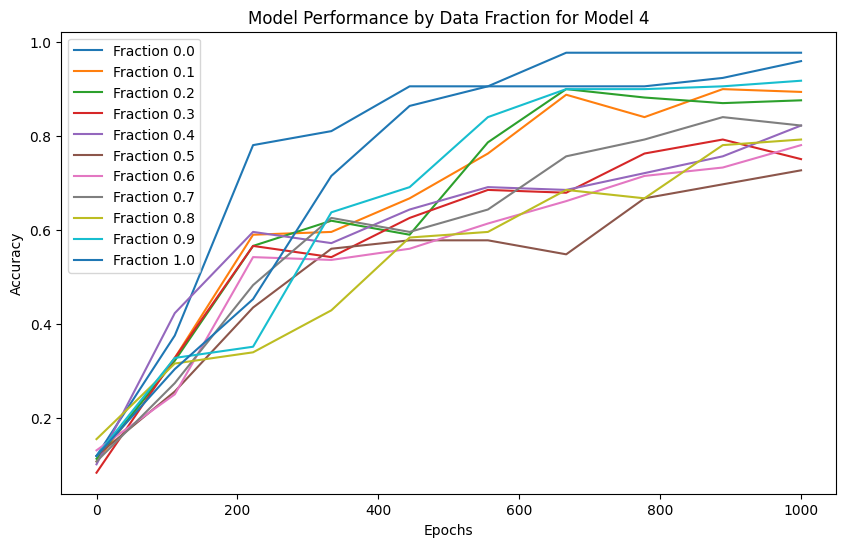

Model 5, Fraction 0.00, Epoch 1, Loss: 2.1989
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 101, Loss: 1.8080
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 201, Loss: 1.4028
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 301, Loss: 1.1236
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 401, Loss: 0.9438
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 501, Loss: 0.8163
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 601, Loss: 0.6959
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 701, Loss: 0.5265
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 801, Loss: 0.4252
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 901, Loss: 0.3561
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.10, Epoch 1, Loss: 2.2059
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.10, Epoch 101, Loss: 1.9355
prediction shape torc

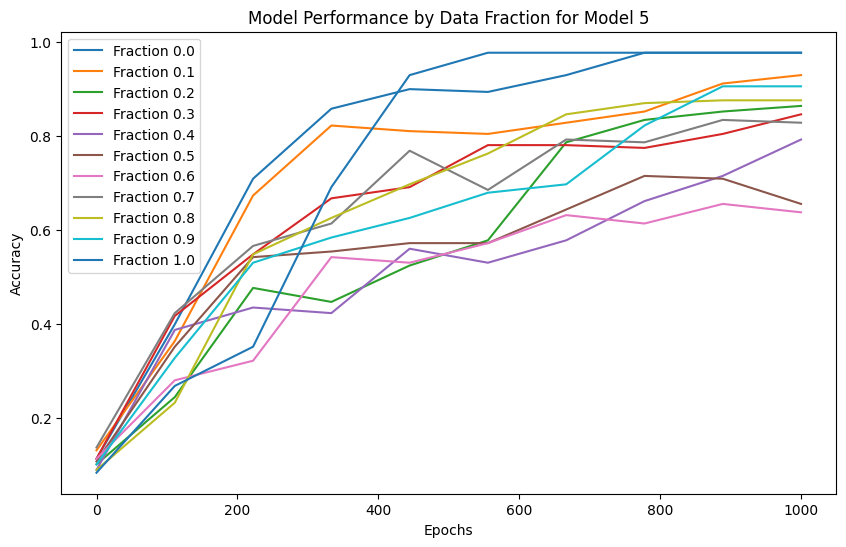

Model 6, Fraction 0.00, Epoch 1, Loss: 2.2128
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 101, Loss: 1.9359
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 201, Loss: 1.4936
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 301, Loss: 1.1267
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 401, Loss: 0.8768
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 501, Loss: 0.6267
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 601, Loss: 0.3965
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 701, Loss: 0.2640
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 801, Loss: 0.1985
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 901, Loss: 0.1600
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.10, Epoch 1, Loss: 2.1941
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.10, Epoch 101, Loss: 1.9250
prediction shape torc

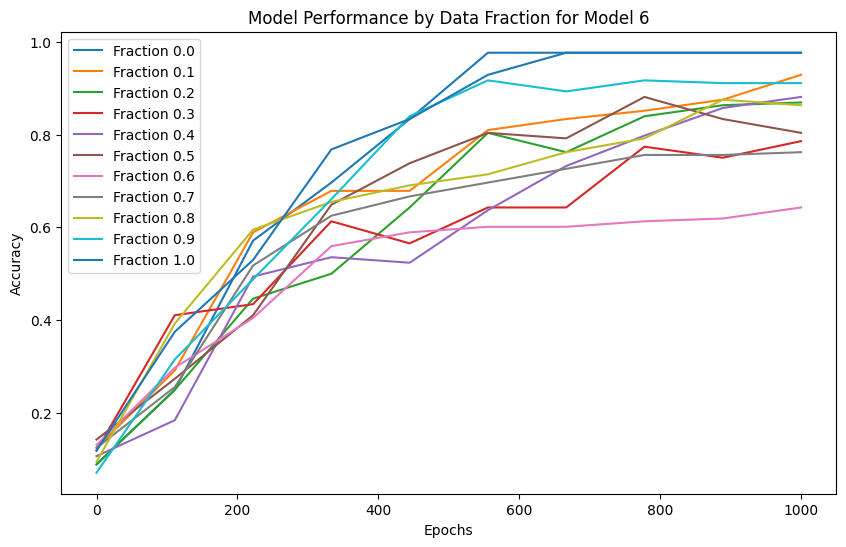

Model 7, Fraction 0.00, Epoch 1, Loss: 2.1965
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 101, Loss: 1.9219
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 201, Loss: 1.4088
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 301, Loss: 0.9926
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 401, Loss: 0.7067
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 501, Loss: 0.4786
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 601, Loss: 0.3186
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 701, Loss: 0.2226
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 801, Loss: 0.1728
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 901, Loss: 0.1429
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.10, Epoch 1, Loss: 2.1967
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.10, Epoch 101, Loss: 1.8906
prediction shape torc

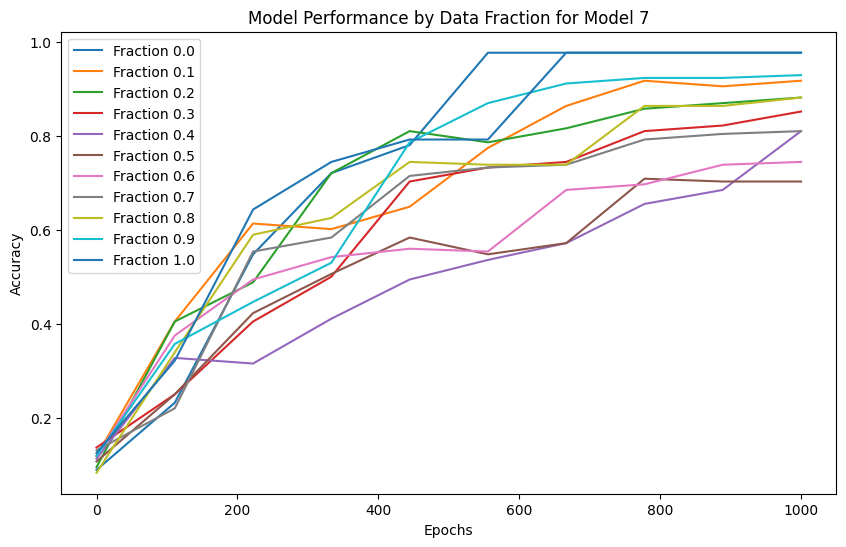

Model 8, Fraction 0.00, Epoch 1, Loss: 2.2036
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 101, Loss: 1.8314
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 201, Loss: 1.3524
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 301, Loss: 1.0354
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 401, Loss: 0.7933
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 501, Loss: 0.6271
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 601, Loss: 0.4877
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 701, Loss: 0.3633
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 801, Loss: 0.2708
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 901, Loss: 0.2084
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.10, Epoch 1, Loss: 2.1990
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.10, Epoch 101, Loss: 1.9592
prediction shape torc

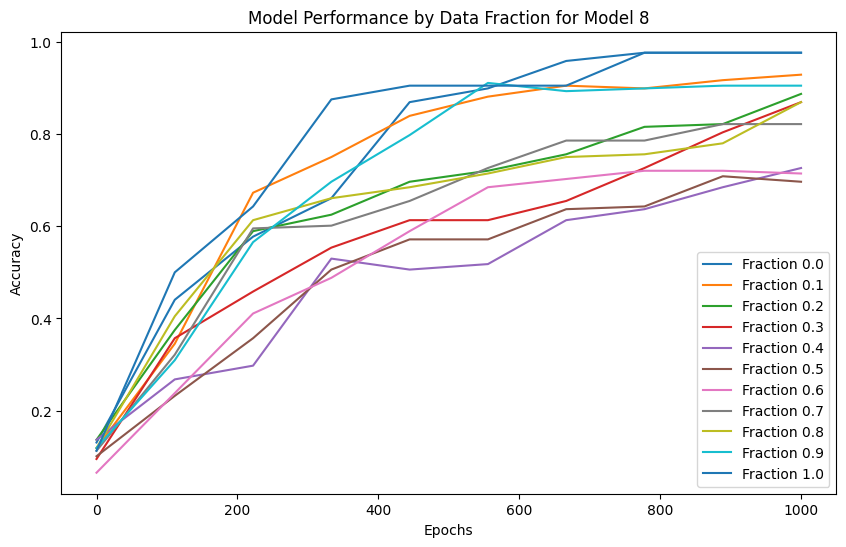

Model 9, Fraction 0.00, Epoch 1, Loss: 2.2032
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 101, Loss: 1.8490
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 201, Loss: 1.3993
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 301, Loss: 1.0366
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 401, Loss: 0.7481
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 501, Loss: 0.5351
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 601, Loss: 0.3917
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 701, Loss: 0.2890
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 801, Loss: 0.2199
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 901, Loss: 0.1756
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.10, Epoch 1, Loss: 2.2016
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.10, Epoch 101, Loss: 1.9024
prediction shape torc

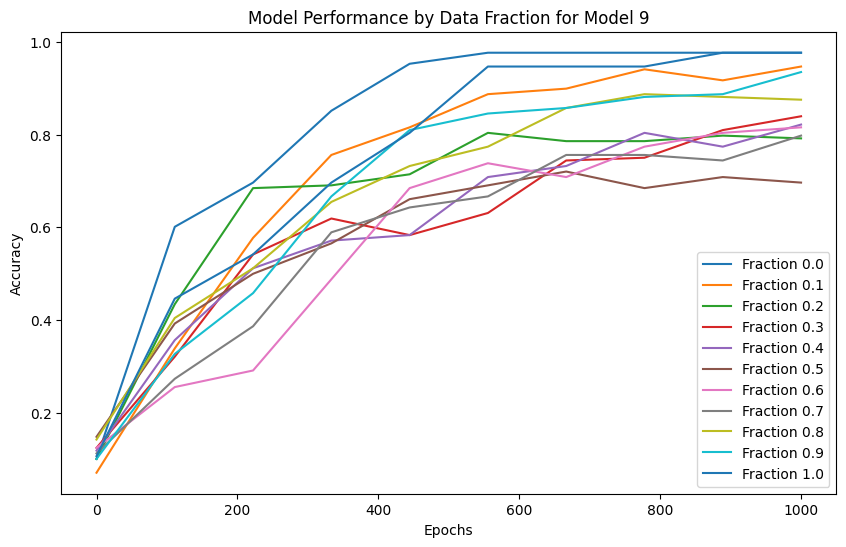

In [79]:
## import os
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt

# Parameters
ntokens = 9
emsize = 4
nhead = 2
d_hid = 4
nlayers = 2
dropout = 0.03
learning_rate = 1e-3
num_epochs = 1000
fractions = np.arange(0, 101, 10) / 100
num_models = 10  # Train 30 different models

songStrings = np.array([
    #"CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC",
    # "ABCDEFGHIABCDEFGHIABCDEFGHIABCDEFGHIABCDEF",
    # "ABCDAFGHIEBCDEAGHIAFCDEFIHIABADEFGCIABCBEF"
    "AHCFEDGBIAHCFEDGBIAHCFEDGBIAHCFEDGBIAHCFED",
    "ABCDEFGHIABCDEFGHIABCDEFGHIABCDEFGHIABCDEF"
    #"ABCDEFIGHABCDEFIGHABCDEFIGHABCDEFIGHABCDEF"
])

for model_idx in range(num_models):
    model_dir = f"Songs_different_lower_parameter/model_{model_idx}"
    os.makedirs(model_dir, exist_ok=True)

    source, target = getTrainingData(songStrings, 2)
    fraction_accuracies = {}

    for fraction in fractions:
        model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)
        W = []
        model.train()
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        input_list, output_list = split_and_shuffle_data_randomly_based_on_fraction(source, target, fraction)

        for epoch in range(num_epochs):
            optimizer.zero_grad()
            source_tensor = torch.tensor(input_list, dtype=torch.long)
            target_tensor = torch.tensor(output_list, dtype=torch.long)

            src = source_tensor.transpose(0, 1)
            tgt = target_tensor.transpose(0, 1)

            output = model(src)
            loss = criterion(output.view(-1, model.ntokens), tgt.reshape(-1))
            loss.backward()
            optimizer.step()

            if epoch % 100 == 0:
                avg_loss = loss.item()
                print(f'Model {model_idx}, Fraction {fraction:.2f}, Epoch {epoch+1}, Loss: {avg_loss:.4f}')
                acc = test(model, source_tensor, target_tensor)
                W.append(acc)
            
            input_list, output_list = split_and_shuffle_data_randomly_based_on_fraction(source, target, fraction)

        fraction_accuracies[fraction] = W
        model_save_path = os.path.join(model_dir, f'model_at_fraction_{fraction:.2f}.pt')
        torch.save(model.state_dict(), model_save_path)

    # Optionally plot accuracies for each model or save the data for further analysis
    plt.figure(figsize=(10, 6))
    for fraction, accuracies in fraction_accuracies.items():
        epochs = np.linspace(0, num_epochs, len(accuracies))
        plt.plot(epochs, accuracies, label=f'Fraction {fraction}')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Model Performance by Data Fraction for Model {model_idx}')
    plt.legend()
    plt.show()


In [81]:
import os
import numpy as np
import torch

# Assuming TransformerModel and necessary data functions are properly defined
# Initialize the model parameters (keep these consistent with training)
ntokens = 9
emsize = 4
nhead = 2
d_hid = 4
nlayers = 2
dropout = 0.03

# Define the directory where models are saved
base_model_dir = "Songs_different_lower_parameter"

# Fractions and song strings for which models were trained
fractions = np.arange(0, 101, 10) / 100
songStrings = np.array([
    "AHCFEDGBIAHCFEDGBIAHCFEDGBIAHCFEDGBIAHCFED",
    "ABCDEFGHIABCDEFGHIABCDEFGHIABCDEFGHIABCDEF"
])

# Array to store accuracies
accuracies = np.zeros((len(fractions), len(songStrings), num_models))  # Added a dimension for models

# Load and test each model for each fraction and song
for model_idx in range(num_models):  # You trained 10 models
    for frac_idx, fraction in enumerate(fractions):
        for song_idx, song in enumerate(songStrings):
            model_dir = f"{base_model_dir}/model_{model_idx}"
            model_path = os.path.join(model_dir, f'model_at_fraction_{fraction:.2f}.pt')
            
            # Load model if it exists
            if os.path.exists(model_path):
                model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)
                model.load_state_dict(torch.load(model_path))
                model.eval()

                source, target = getTrainingData(np.array([song]), 1)
                source_tensor = torch.tensor(source, dtype=torch.long)
                target_tensor = torch.tensor(target, dtype=torch.long)

                with torch.no_grad():
                    src = source_tensor.transpose(0, 1)
                    tgt = target_tensor.transpose(0, 1)
                    output = model(src)
                    predictions = output.argmax(dim=2)

                    correct = (predictions == tgt).sum().item()
                    total = tgt.numel()

                    accuracy = correct / total
                    accuracies[frac_idx, song_idx, model_idx] = accuracy
            else:
                print(f"Model not found: {model_path}")

# Optionally, average accuracies across all models for each song and fraction
average_accuracies = accuracies.mean(axis=2)  # Average over the model dimension

# Print or process the average accuracies array as needed
for song_idx, song in enumerate(songStrings):
    print(f"Accuracies for Song {song_idx + 1}:")
    for frac_idx, fraction in enumerate(fractions):
        print(f"  Fraction {fraction:.2f}, Average Accuracy: {average_accuracies[frac_idx, song_idx]:.4f}")


Accuracies for Song 1:
  Fraction 0.00, Average Accuracy: 0.1119
  Fraction 0.10, Average Accuracy: 0.4887
  Fraction 0.20, Average Accuracy: 0.4696
  Fraction 0.30, Average Accuracy: 0.5613
  Fraction 0.40, Average Accuracy: 0.6536
  Fraction 0.50, Average Accuracy: 0.7345
  Fraction 0.60, Average Accuracy: 0.8196
  Fraction 0.70, Average Accuracy: 0.9256
  Fraction 0.80, Average Accuracy: 0.9470
  Fraction 0.90, Average Accuracy: 0.9762
  Fraction 1.00, Average Accuracy: 0.9732
Accuracies for Song 2:
  Fraction 0.00, Average Accuracy: 0.9762
  Fraction 0.10, Average Accuracy: 0.9726
  Fraction 0.20, Average Accuracy: 0.9714
  Fraction 0.30, Average Accuracy: 0.9155
  Fraction 0.40, Average Accuracy: 0.8738
  Fraction 0.50, Average Accuracy: 0.7304
  Fraction 0.60, Average Accuracy: 0.6244
  Fraction 0.70, Average Accuracy: 0.5506
  Fraction 0.80, Average Accuracy: 0.5310
  Fraction 0.90, Average Accuracy: 0.5036
  Fraction 1.00, Average Accuracy: 0.1036


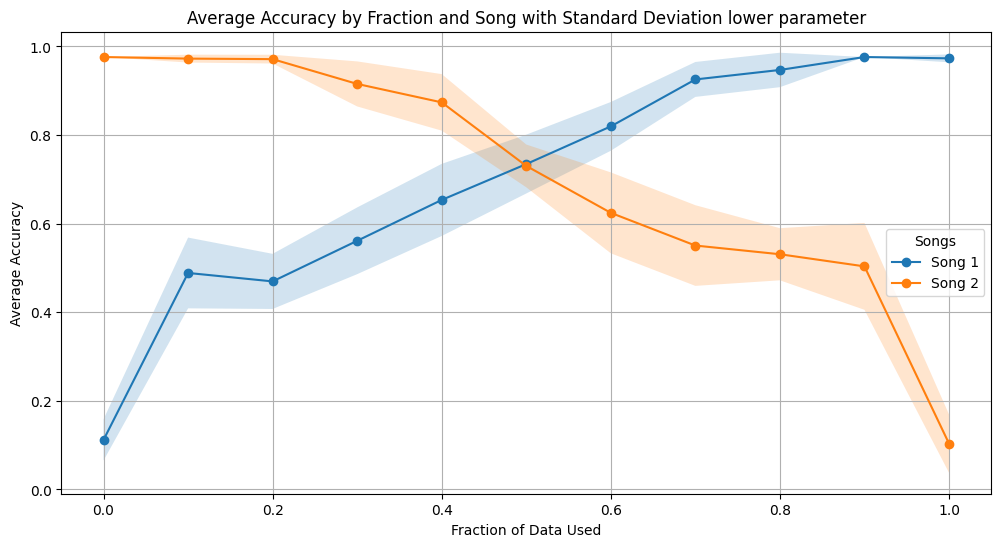

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming accuracies are already calculated and available
# Calculate the average accuracies and standard deviation across all models for each song and fraction
average_accuracies = accuracies.mean(axis=2)  # Average over the model dimension
std_dev_accuracies = accuracies.std(axis=2)  # Standard deviation over the model dimension

# Plotting the accuracies with standard deviation
plt.figure(figsize=(12, 6))
for song_idx, song in enumerate(songStrings):
    # Generate the x-values for the fractions
    x_values = fractions
    y_values = average_accuracies[:, song_idx]
    y_err = std_dev_accuracies[:, song_idx]

    plt.plot(x_values, y_values, marker='o', label=f'Song {song_idx + 1}')
    plt.fill_between(x_values, (y_values - y_err), (y_values + y_err), alpha=0.2)

plt.title('Average Accuracy by Fraction and Song with Standard Deviation lower parameter')
plt.xlabel('Fraction of Data Used')
plt.ylabel('Average Accuracy')
plt.legend(title="Songs")
plt.grid(True)
plt.show()


## training and testing for different harder songs

Model 0, Fraction 0.00, Epoch 1, Loss: 2.1959
prediction shape torch.Size([4, 42])


/var/folders/wn/f4cc27tx13g8w1qgpzb2bsrm0000gn/T/ipykernel_27373/2366339544.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source = torch.tensor(source, dtype=torch.long)
/var/folders/wn/f4cc27tx13g8w1qgpzb2bsrm0000gn/T/ipykernel_27373/2366339544.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, dtype=torch.long)


Model 0, Fraction 0.00, Epoch 101, Loss: 1.1846
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 201, Loss: 0.6105
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 301, Loss: 0.4664
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 401, Loss: 0.4310
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 501, Loss: 0.4167
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 601, Loss: 0.4093
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 701, Loss: 0.4057
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 801, Loss: 0.4020
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 901, Loss: 0.4004
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 1001, Loss: 0.3987
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 1101, Loss: 0.3977
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 1201, Loss: 0.3973
prediction sha

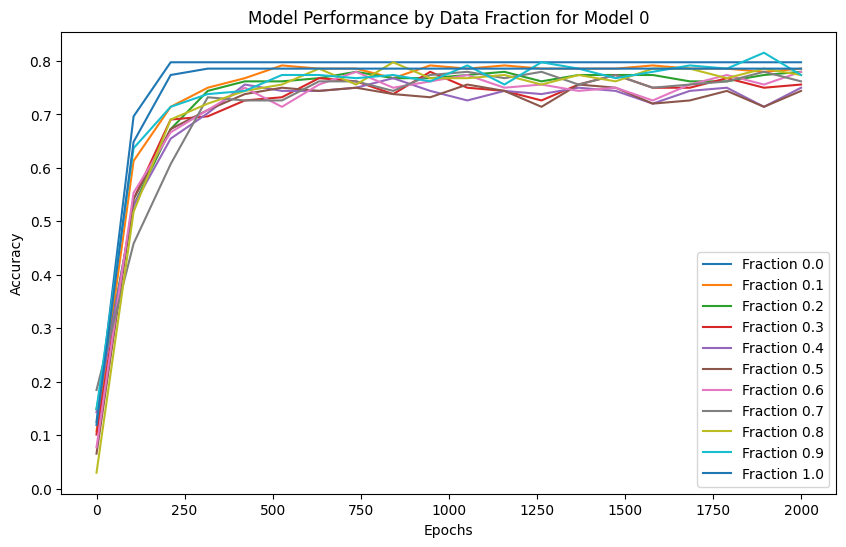

Model 1, Fraction 0.00, Epoch 1, Loss: 2.1850
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 101, Loss: 1.1365
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 201, Loss: 0.5964
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 301, Loss: 0.4609
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 401, Loss: 0.4281
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 501, Loss: 0.4161
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 601, Loss: 0.4082
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 701, Loss: 0.4040
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 801, Loss: 0.4014
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 901, Loss: 0.3996
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 1001, Loss: 0.3986
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 1101, Loss: 0.3975
prediction shape 

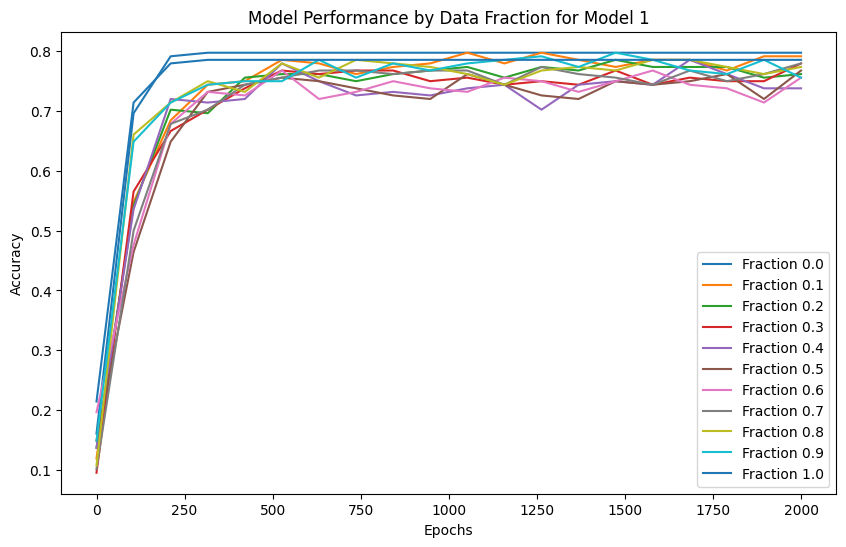

Model 2, Fraction 0.00, Epoch 1, Loss: 2.2330
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 101, Loss: 1.1923
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 201, Loss: 0.7036
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 301, Loss: 0.4972
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 401, Loss: 0.4385
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 501, Loss: 0.4197
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 601, Loss: 0.4108
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 701, Loss: 0.4061
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 801, Loss: 0.4027
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 901, Loss: 0.4006
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 1001, Loss: 0.3990
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 1101, Loss: 0.3983
prediction shape 

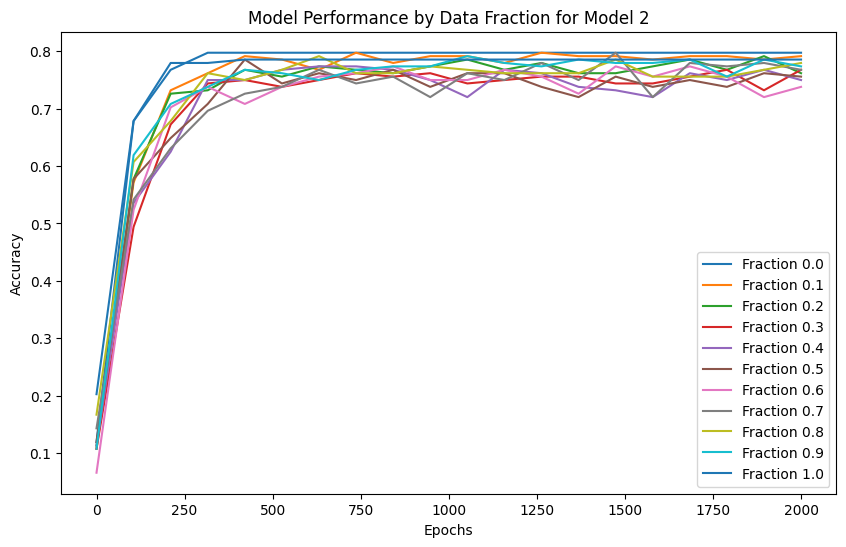

Model 3, Fraction 0.00, Epoch 1, Loss: 2.2401
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 101, Loss: 1.2117
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 201, Loss: 0.6268
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 301, Loss: 0.4678
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 401, Loss: 0.4312
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 501, Loss: 0.4162
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 601, Loss: 0.4090
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 701, Loss: 0.4044
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 801, Loss: 0.4016
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 901, Loss: 0.4000
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 1001, Loss: 0.4011
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 1101, Loss: 0.3992
prediction shape 

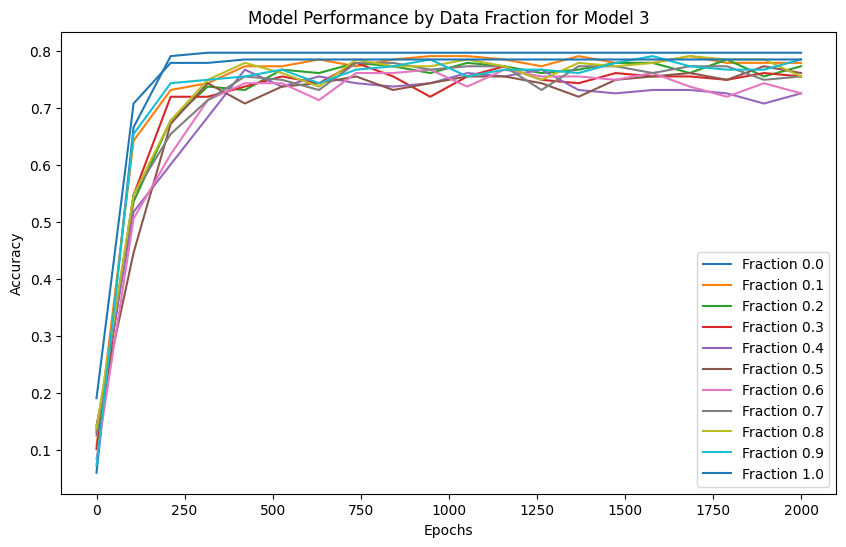

Model 4, Fraction 0.00, Epoch 1, Loss: 2.1969
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 101, Loss: 1.1517
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 201, Loss: 0.6582
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 301, Loss: 0.4795
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 401, Loss: 0.4335
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 501, Loss: 0.4176
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 601, Loss: 0.4109
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 701, Loss: 0.4050
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 801, Loss: 0.4035
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 901, Loss: 0.4002
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 1001, Loss: 0.3988
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 1101, Loss: 0.3978
prediction shape 

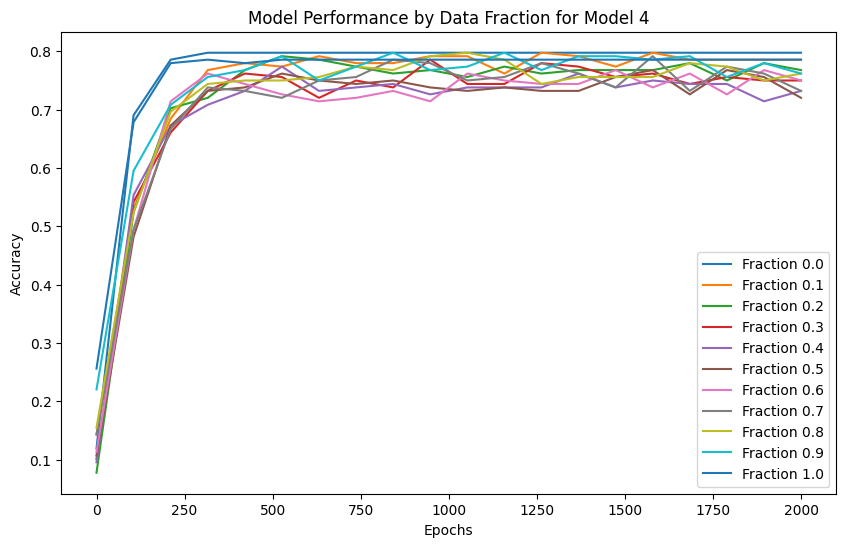

Model 5, Fraction 0.00, Epoch 1, Loss: 2.2076
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 101, Loss: 1.1962
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 201, Loss: 0.6777
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 301, Loss: 0.4800
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 401, Loss: 0.4312
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 501, Loss: 0.4163
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 601, Loss: 0.4080
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 701, Loss: 0.4051
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 801, Loss: 0.4012
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 901, Loss: 0.3996
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 1001, Loss: 0.3995
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 1101, Loss: 0.3973
prediction shape 

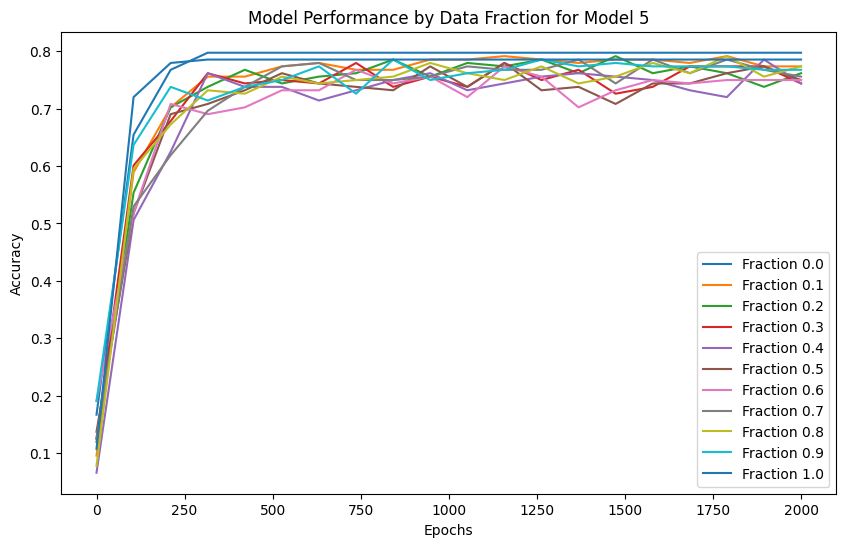

Model 6, Fraction 0.00, Epoch 1, Loss: 2.2512
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 101, Loss: 1.2259
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 201, Loss: 0.6625
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 301, Loss: 0.4805
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 401, Loss: 0.4297
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 501, Loss: 0.4150
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 601, Loss: 0.4103
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 701, Loss: 0.4039
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 801, Loss: 0.4013
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 901, Loss: 0.3993
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 1001, Loss: 0.3981
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 1101, Loss: 0.3972
prediction shape 

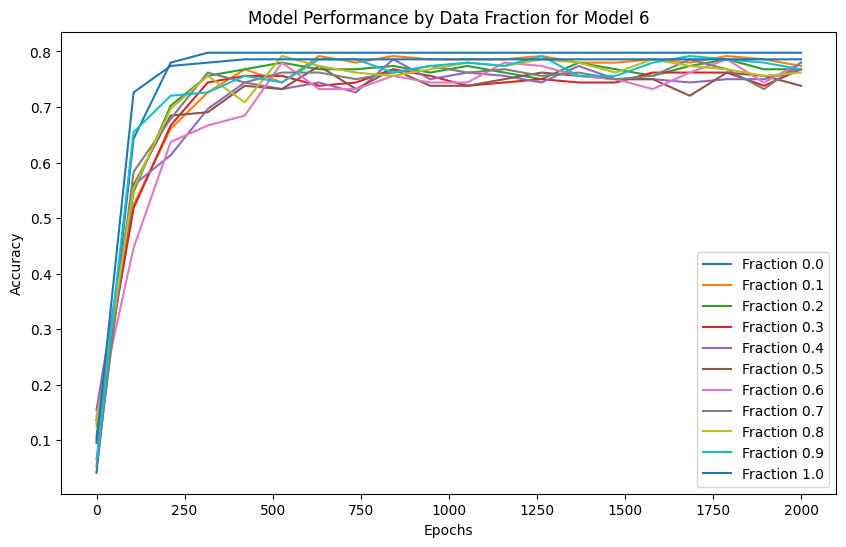

Model 7, Fraction 0.00, Epoch 1, Loss: 2.2213
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 101, Loss: 1.1941
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 201, Loss: 0.6315
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 301, Loss: 0.4718
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 401, Loss: 0.4320
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 501, Loss: 0.4167
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 601, Loss: 0.4091
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 701, Loss: 0.4045
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 801, Loss: 0.4022
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 901, Loss: 0.3999
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 1001, Loss: 0.3985
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 1101, Loss: 0.3977
prediction shape 

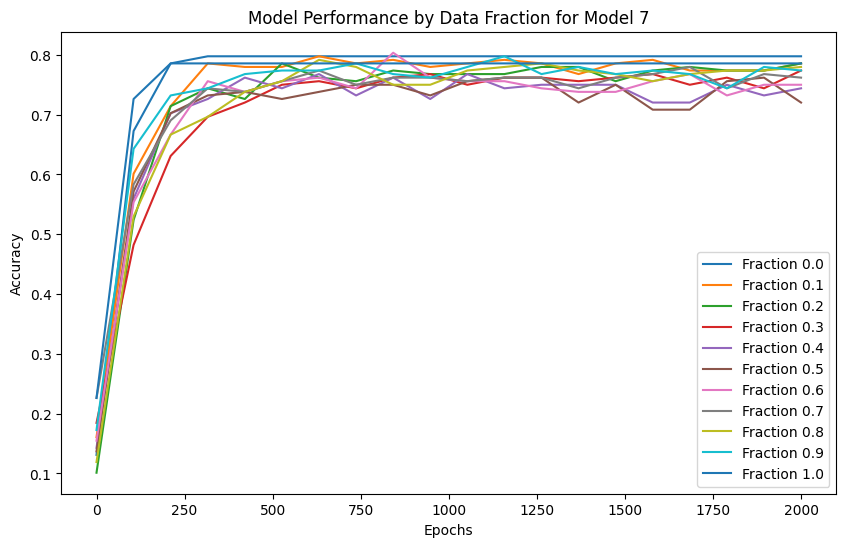

Model 8, Fraction 0.00, Epoch 1, Loss: 2.2094
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 101, Loss: 1.1781
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 201, Loss: 0.6447
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 301, Loss: 0.4696
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 401, Loss: 0.4309
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 501, Loss: 0.4154
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 601, Loss: 0.4080
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 701, Loss: 0.4039
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 801, Loss: 0.4015
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 901, Loss: 0.3994
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 1001, Loss: 0.3990
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 1101, Loss: 0.3976
prediction shape 

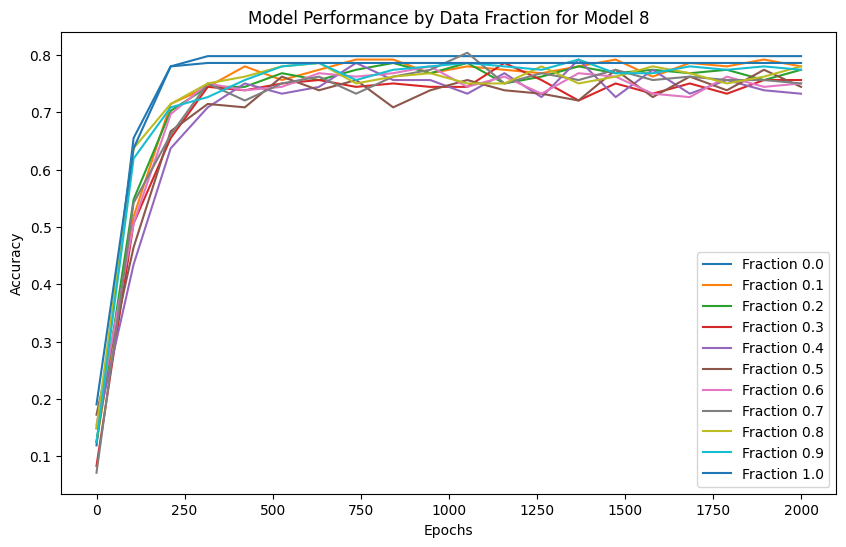

Model 9, Fraction 0.00, Epoch 1, Loss: 2.2471
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 101, Loss: 1.2276
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 201, Loss: 0.6303
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 301, Loss: 0.4673
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 401, Loss: 0.4306
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 501, Loss: 0.4168
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 601, Loss: 0.4087
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 701, Loss: 0.4044
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 801, Loss: 0.4017
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 901, Loss: 0.3998
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 1001, Loss: 0.3988
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 1101, Loss: 0.3976
prediction shape 

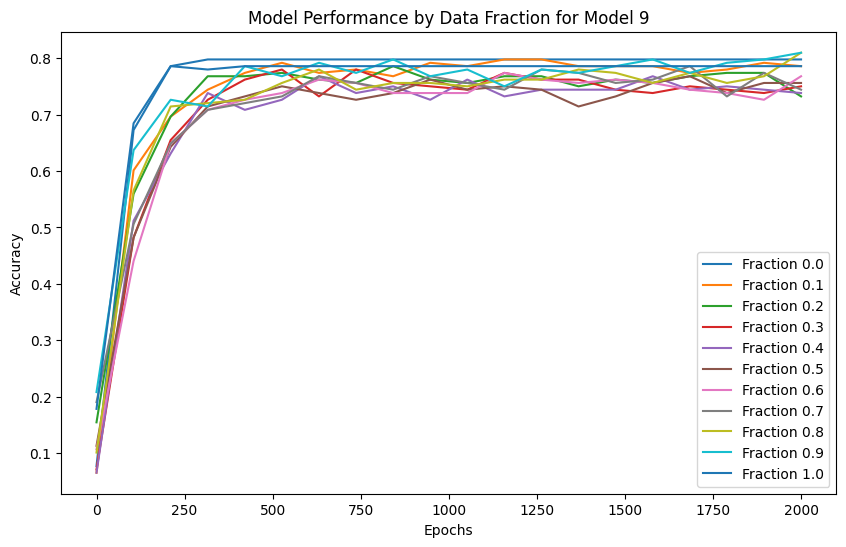

In [89]:
## import os
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt

# Parameters
ntokens = 9
emsize = 14
nhead = 2
d_hid = 14
nlayers = 4
dropout = 0.03
learning_rate = 1e-3
num_epochs = 2000
fractions = np.arange(0, 101, 10) / 100
num_models = 10  # Train 30 different models

songStrings = np.array([
    "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC",
    "ABCDAFGHIEBCDEAGHIAFCDEFIHIABADEFGCIABCBEF"
])

for model_idx in range(num_models):
    model_dir = f"Songs_different_hard_songs/model_{model_idx}"
    os.makedirs(model_dir, exist_ok=True)

    source, target = getTrainingData(songStrings, 2)
    fraction_accuracies = {}

    for fraction in fractions:
        model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)
        W = []
        model.train()
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        input_list, output_list = split_and_shuffle_data_randomly_based_on_fraction(source, target, fraction)

        for epoch in range(num_epochs):
            optimizer.zero_grad()
            source_tensor = torch.tensor(input_list, dtype=torch.long)
            target_tensor = torch.tensor(output_list, dtype=torch.long)

            src = source_tensor.transpose(0, 1)
            tgt = target_tensor.transpose(0, 1)

            output = model(src)
            loss = criterion(output.view(-1, model.ntokens), tgt.reshape(-1))
            loss.backward()
            optimizer.step()

            if epoch % 100 == 0:
                avg_loss = loss.item()
                print(f'Model {model_idx}, Fraction {fraction:.2f}, Epoch {epoch+1}, Loss: {avg_loss:.4f}')
                acc = test(model, source_tensor, target_tensor)
                W.append(acc)
            
            input_list, output_list = split_and_shuffle_data_randomly_based_on_fraction(source, target, fraction)

        fraction_accuracies[fraction] = W
        model_save_path = os.path.join(model_dir, f'model_at_fraction_{fraction:.2f}.pt')
        torch.save(model.state_dict(), model_save_path)

    # Optionally plot accuracies for each model or save the data for further analysis
    plt.figure(figsize=(10, 6))
    for fraction, accuracies in fraction_accuracies.items():
        epochs = np.linspace(0, num_epochs, len(accuracies))
        plt.plot(epochs, accuracies, label=f'Fraction {fraction}')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Model Performance by Data Fraction for Model {model_idx}')
    plt.legend()
    plt.show()


In [90]:
import os
import numpy as np
import torch

# Assuming TransformerModel and necessary data functions are properly defined
# Initialize the model parameters (keep these consistent with training)
ntokens = 9
emsize = 14
nhead = 2
d_hid = 14
nlayers = 4
dropout = 0.03

# Define the directory where models are saved
base_model_dir = "Songs_different_hard_songs"

# Fractions and song strings for which models were trained
fractions = np.arange(0, 101, 10) / 100
songStrings = np.array([
    "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC",
    "ABCDAFGHIEBCDEAGHIAFCDEFIHIABADEFGCIABCBEF"
])

# Array to store accuracies
accuracies = np.zeros((len(fractions), len(songStrings), num_models))  # Added a dimension for models

# Load and test each model for each fraction and song
for model_idx in range(num_models):  # You trained 10 models
    for frac_idx, fraction in enumerate(fractions):
        for song_idx, song in enumerate(songStrings):
            model_dir = f"{base_model_dir}/model_{model_idx}"
            model_path = os.path.join(model_dir, f'model_at_fraction_{fraction:.2f}.pt')
            
            # Load model if it exists
            if os.path.exists(model_path):
                model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)
                model.load_state_dict(torch.load(model_path))
                model.eval()

                source, target = getTrainingData(np.array([song]), 1)
                source_tensor = torch.tensor(source, dtype=torch.long)
                target_tensor = torch.tensor(target, dtype=torch.long)

                with torch.no_grad():
                    src = source_tensor.transpose(0, 1)
                    tgt = target_tensor.transpose(0, 1)
                    output = model(src)
                    predictions = output.argmax(dim=2)

                    correct = (predictions == tgt).sum().item()
                    total = tgt.numel()

                    accuracy = correct / total
                    accuracies[frac_idx, song_idx, model_idx] = accuracy
            else:
                print(f"Model not found: {model_path}")

# Optionally, average accuracies across all models for each song and fraction
average_accuracies = accuracies.mean(axis=2)  # Average over the model dimension

# Print or process the average accuracies array as needed
for song_idx, song in enumerate(songStrings):
    print(f"Accuracies for Song {song_idx + 1}:")
    for frac_idx, fraction in enumerate(fractions):
        print(f"  Fraction {fraction:.2f}, Average Accuracy: {average_accuracies[frac_idx, song_idx]:.4f}")


Accuracies for Song 1:
  Fraction 0.00, Average Accuracy: 0.0149
  Fraction 0.10, Average Accuracy: 0.6452
  Fraction 0.20, Average Accuracy: 0.6476
  Fraction 0.30, Average Accuracy: 0.6845
  Fraction 0.40, Average Accuracy: 0.7161
  Fraction 0.50, Average Accuracy: 0.7625
  Fraction 0.60, Average Accuracy: 0.7827
  Fraction 0.70, Average Accuracy: 0.7821
  Fraction 0.80, Average Accuracy: 0.7851
  Fraction 0.90, Average Accuracy: 0.7845
  Fraction 1.00, Average Accuracy: 0.7857
Accuracies for Song 2:
  Fraction 0.00, Average Accuracy: 0.7976
  Fraction 0.10, Average Accuracy: 0.7964
  Fraction 0.20, Average Accuracy: 0.7964
  Fraction 0.30, Average Accuracy: 0.7786
  Fraction 0.40, Average Accuracy: 0.7607
  Fraction 0.50, Average Accuracy: 0.7173
  Fraction 0.60, Average Accuracy: 0.6988
  Fraction 0.70, Average Accuracy: 0.7006
  Fraction 0.80, Average Accuracy: 0.6952
  Fraction 0.90, Average Accuracy: 0.6940
  Fraction 1.00, Average Accuracy: 0.0607


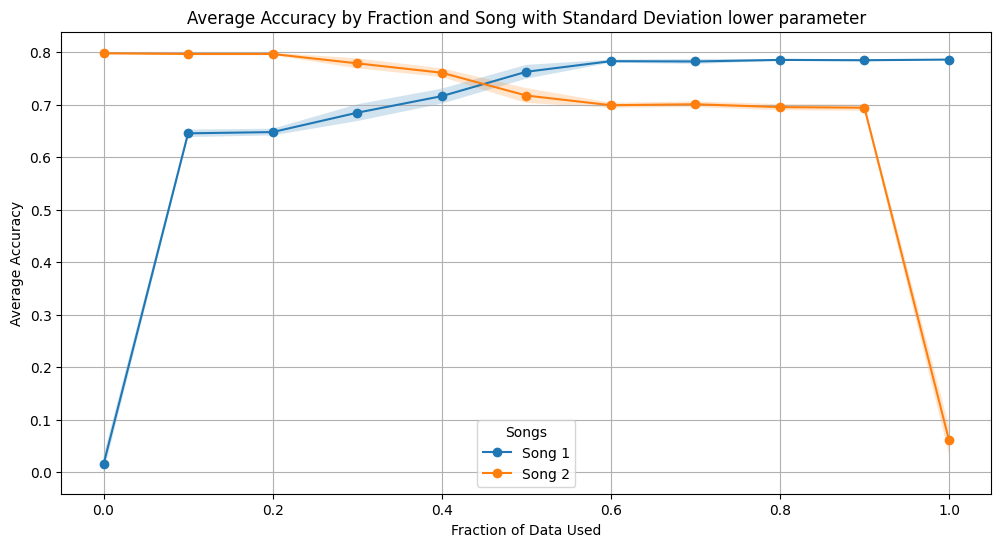

In [92]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming accuracies are already calculated and available
# Calculate the average accuracies and standard deviation across all models for each song and fraction
average_accuracies = accuracies.mean(axis=2)  # Average over the model dimension
std_dev_accuracies = accuracies.std(axis=2)  # Standard deviation over the model dimension

# Plotting the accuracies with standard deviation
plt.figure(figsize=(12, 6))
for song_idx, song in enumerate(songStrings):
    # Generate the x-values for the fractions
    x_values = fractions
    y_values = average_accuracies[:, song_idx]
    y_err = std_dev_accuracies[:, song_idx]

    plt.plot(x_values, y_values, marker='o', label=f'Song {song_idx + 1}')
    plt.fill_between(x_values, (y_values - y_err), (y_values + y_err), alpha=0.2)

plt.title('Average Accuracy by Fraction and Song with Standard Deviation lower parameter')
plt.xlabel('Fraction of Data Used')
plt.ylabel('Average Accuracy')
plt.legend(title="Songs")
plt.grid(True)
plt.show()


## training and testing for different harder songs with lower parameter

Model 0, Fraction 0.00, Epoch 1, Loss: 2.2012
prediction shape torch.Size([4, 42])


/var/folders/wn/f4cc27tx13g8w1qgpzb2bsrm0000gn/T/ipykernel_27373/2366339544.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source = torch.tensor(source, dtype=torch.long)
/var/folders/wn/f4cc27tx13g8w1qgpzb2bsrm0000gn/T/ipykernel_27373/2366339544.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, dtype=torch.long)


Model 0, Fraction 0.00, Epoch 101, Loss: 2.0842
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 201, Loss: 1.6318
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 301, Loss: 1.3767
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 401, Loss: 1.2373
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 501, Loss: 1.1173
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 601, Loss: 0.9911
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 701, Loss: 0.8925
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 801, Loss: 0.8237
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 901, Loss: 0.7696
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 1001, Loss: 0.7233
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 1101, Loss: 0.6854
prediction shape torch.Size([4, 42])
Model 0, Fraction 0.00, Epoch 1201, Loss: 0.6586
prediction sha

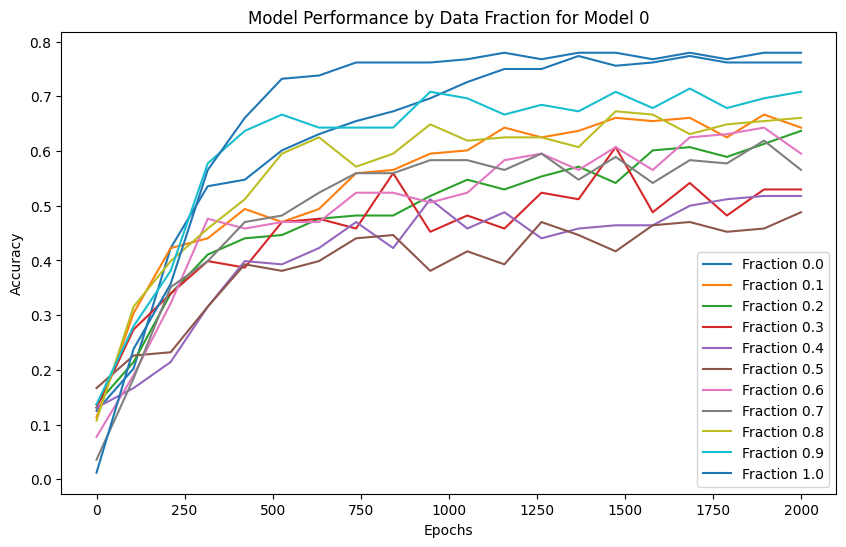

Model 1, Fraction 0.00, Epoch 1, Loss: 2.2016
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 101, Loss: 1.9815
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 201, Loss: 1.5408
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 301, Loss: 1.3354
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 401, Loss: 1.2041
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 501, Loss: 1.0997
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 601, Loss: 0.9967
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 701, Loss: 0.9130
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 801, Loss: 0.8505
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 901, Loss: 0.8074
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 1001, Loss: 0.7743
prediction shape torch.Size([4, 42])
Model 1, Fraction 0.00, Epoch 1101, Loss: 0.7514
prediction shape 

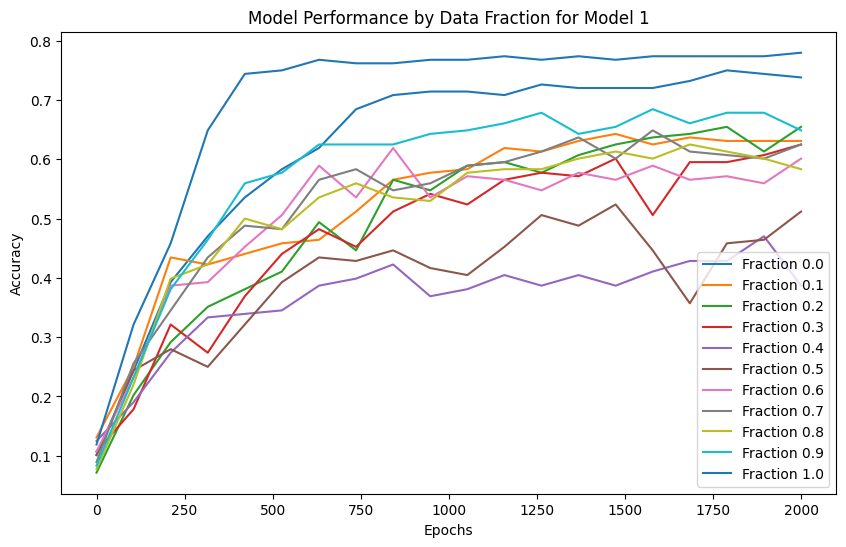

Model 2, Fraction 0.00, Epoch 1, Loss: 2.1930
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 101, Loss: 1.9265
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 201, Loss: 1.6109
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 301, Loss: 1.3370
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 401, Loss: 1.1339
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 501, Loss: 1.0167
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 601, Loss: 0.9520
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 701, Loss: 0.9035
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 801, Loss: 0.8641
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 901, Loss: 0.8348
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 1001, Loss: 0.8074
prediction shape torch.Size([4, 42])
Model 2, Fraction 0.00, Epoch 1101, Loss: 0.7884
prediction shape 

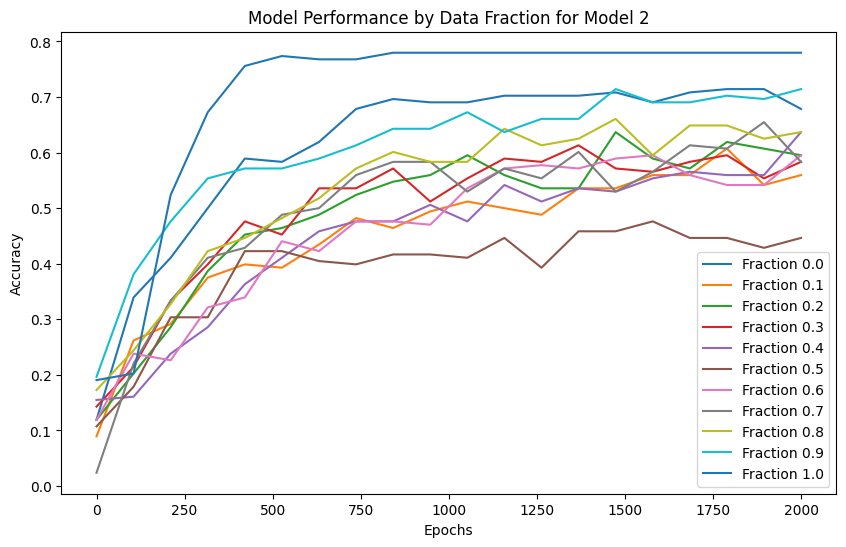

Model 3, Fraction 0.00, Epoch 1, Loss: 2.2129
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 101, Loss: 2.0315
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 201, Loss: 1.6245
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 301, Loss: 1.3691
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 401, Loss: 1.2423
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 501, Loss: 1.1575
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 601, Loss: 1.0603
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 701, Loss: 0.9584
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 801, Loss: 0.8776
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 901, Loss: 0.8312
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 1001, Loss: 0.7796
prediction shape torch.Size([4, 42])
Model 3, Fraction 0.00, Epoch 1101, Loss: 0.7545
prediction shape 

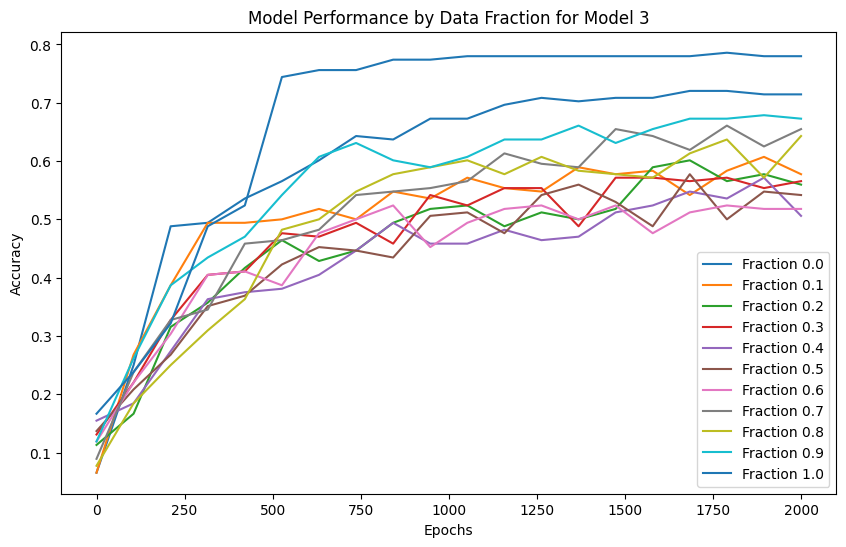

Model 4, Fraction 0.00, Epoch 1, Loss: 2.1939
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 101, Loss: 1.9596
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 201, Loss: 1.6212
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 301, Loss: 1.3962
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 401, Loss: 1.2681
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 501, Loss: 1.1624
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 601, Loss: 1.0838
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 701, Loss: 1.0253
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 801, Loss: 0.9698
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 901, Loss: 0.9244
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 1001, Loss: 0.8885
prediction shape torch.Size([4, 42])
Model 4, Fraction 0.00, Epoch 1101, Loss: 0.8541
prediction shape 

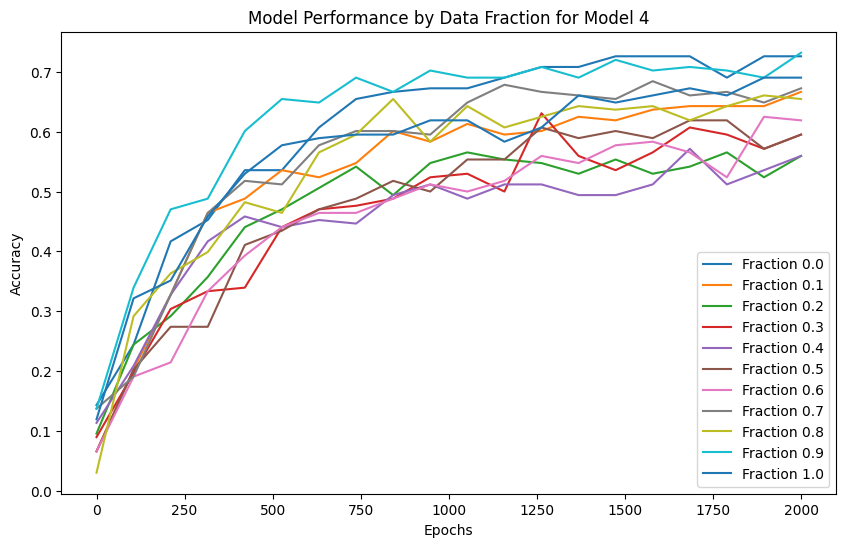

Model 5, Fraction 0.00, Epoch 1, Loss: 2.2063
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 101, Loss: 2.0322
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 201, Loss: 1.6941
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 301, Loss: 1.3917
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 401, Loss: 1.2318
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 501, Loss: 1.1226
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 601, Loss: 1.0695
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 701, Loss: 1.0373
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 801, Loss: 0.9940
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 901, Loss: 0.9688
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 1001, Loss: 0.9481
prediction shape torch.Size([4, 42])
Model 5, Fraction 0.00, Epoch 1101, Loss: 0.9333
prediction shape 

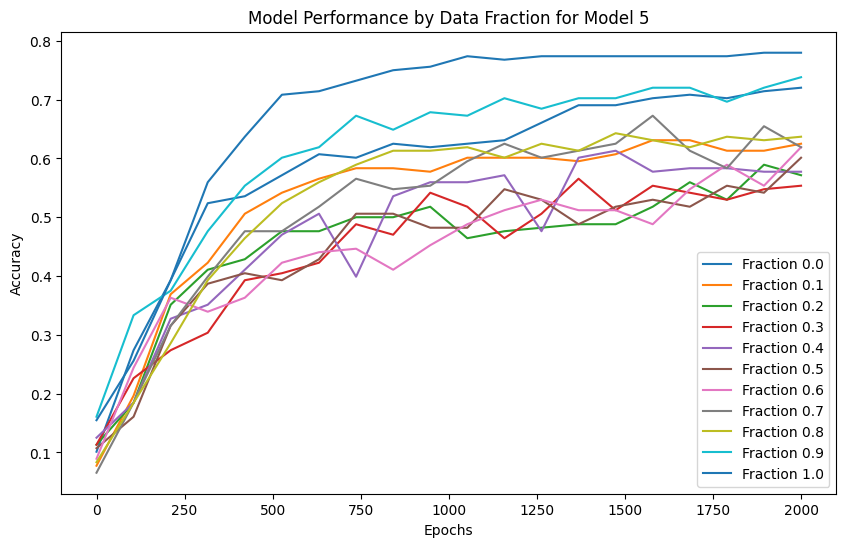

Model 6, Fraction 0.00, Epoch 1, Loss: 2.2031
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 101, Loss: 2.0626
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 201, Loss: 1.6928
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 301, Loss: 1.3736
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 401, Loss: 1.1952
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 501, Loss: 1.0640
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 601, Loss: 0.9795
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 701, Loss: 0.9260
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 801, Loss: 0.8901
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 901, Loss: 0.8624
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 1001, Loss: 0.8537
prediction shape torch.Size([4, 42])
Model 6, Fraction 0.00, Epoch 1101, Loss: 0.8122
prediction shape 

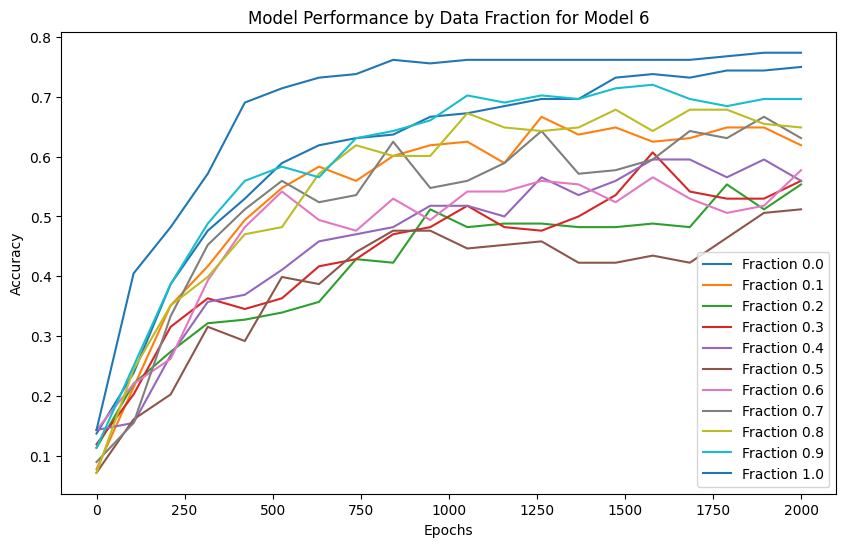

Model 7, Fraction 0.00, Epoch 1, Loss: 2.2094
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 101, Loss: 1.9444
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 201, Loss: 1.6357
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 301, Loss: 1.4190
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 401, Loss: 1.2810
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 501, Loss: 1.1607
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 601, Loss: 1.0763
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 701, Loss: 0.9943
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 801, Loss: 0.9185
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 901, Loss: 0.8560
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 1001, Loss: 0.8042
prediction shape torch.Size([4, 42])
Model 7, Fraction 0.00, Epoch 1101, Loss: 0.7698
prediction shape 

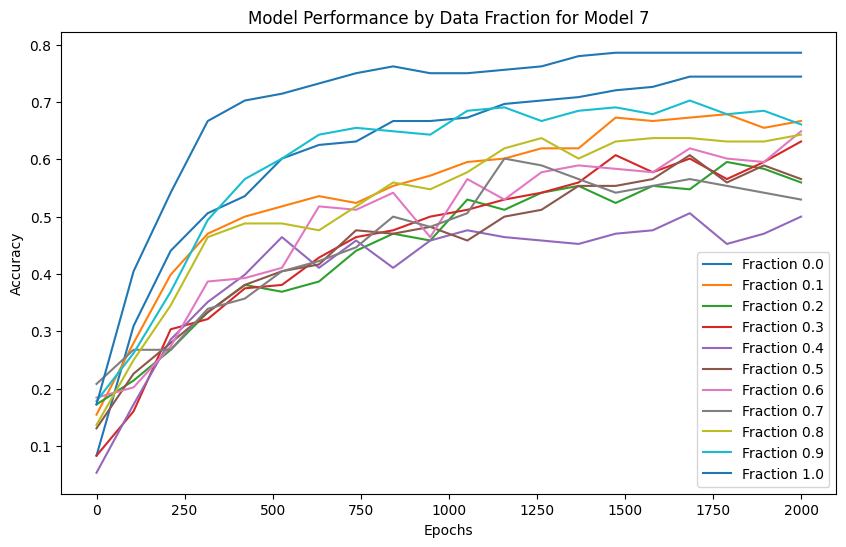

Model 8, Fraction 0.00, Epoch 1, Loss: 2.2085
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 101, Loss: 2.0845
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 201, Loss: 1.7088
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 301, Loss: 1.3359
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 401, Loss: 1.1437
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 501, Loss: 1.0066
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 601, Loss: 0.9411
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 701, Loss: 0.8846
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 801, Loss: 0.8483
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 901, Loss: 0.8143
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 1001, Loss: 0.7773
prediction shape torch.Size([4, 42])
Model 8, Fraction 0.00, Epoch 1101, Loss: 0.7474
prediction shape 

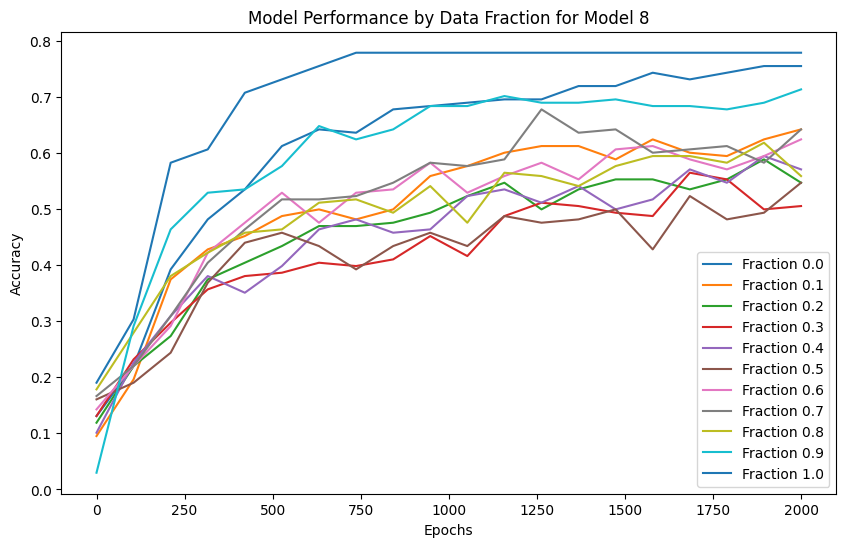

Model 9, Fraction 0.00, Epoch 1, Loss: 2.1995
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 101, Loss: 2.0532
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 201, Loss: 1.7132
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 301, Loss: 1.4248
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 401, Loss: 1.2159
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 501, Loss: 1.0877
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 601, Loss: 1.0108
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 701, Loss: 0.9515
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 801, Loss: 0.9069
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 901, Loss: 0.8741
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 1001, Loss: 0.8487
prediction shape torch.Size([4, 42])
Model 9, Fraction 0.00, Epoch 1101, Loss: 0.8263
prediction shape 

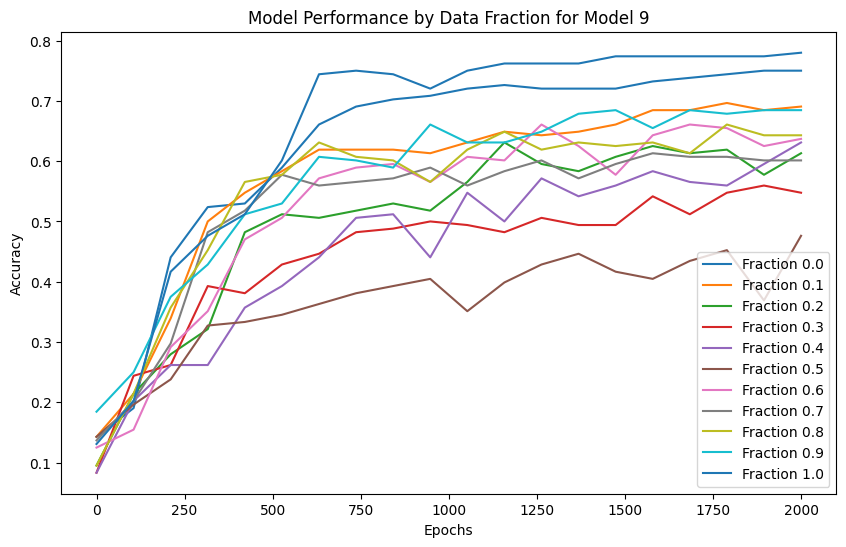

In [94]:
## import os
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt

# Parameters
ntokens = 9
emsize = 4
nhead = 2
d_hid = 4
nlayers = 2
dropout = 0.03
learning_rate = 1e-3
num_epochs = 2000
fractions = np.arange(0, 101, 10) / 100
num_models = 10  # Train 30 different models

songStrings = np.array([
    "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC",
    "ABCDAFGHIEBCDEAGHIAFCDEFIHIABADEFGCIABCBEF"
])

for model_idx in range(num_models):
    model_dir = f"Songs_different_hard_songs_lower_parameter/model_{model_idx}"
    os.makedirs(model_dir, exist_ok=True)

    source, target = getTrainingData(songStrings, 2)
    fraction_accuracies = {}

    for fraction in fractions:
        model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)
        W = []
        model.train()
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        input_list, output_list = split_and_shuffle_data_randomly_based_on_fraction(source, target, fraction)

        for epoch in range(num_epochs):
            optimizer.zero_grad()
            source_tensor = torch.tensor(input_list, dtype=torch.long)
            target_tensor = torch.tensor(output_list, dtype=torch.long)

            src = source_tensor.transpose(0, 1)
            tgt = target_tensor.transpose(0, 1)

            output = model(src)
            loss = criterion(output.view(-1, model.ntokens), tgt.reshape(-1))
            loss.backward()
            optimizer.step()

            if epoch % 100 == 0:
                avg_loss = loss.item()
                print(f'Model {model_idx}, Fraction {fraction:.2f}, Epoch {epoch+1}, Loss: {avg_loss:.4f}')
                acc = test(model, source_tensor, target_tensor)
                W.append(acc)
            
            input_list, output_list = split_and_shuffle_data_randomly_based_on_fraction(source, target, fraction)

        fraction_accuracies[fraction] = W
        model_save_path = os.path.join(model_dir, f'model_at_fraction_{fraction:.2f}.pt')
        torch.save(model.state_dict(), model_save_path)

    # Optionally plot accuracies for each model or save the data for further analysis
    plt.figure(figsize=(10, 6))
    for fraction, accuracies in fraction_accuracies.items():
        epochs = np.linspace(0, num_epochs, len(accuracies))
        plt.plot(epochs, accuracies, label=f'Fraction {fraction}')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Model Performance by Data Fraction for Model {model_idx}')
    plt.legend()
    plt.show()


In [95]:
import os
import numpy as np
import torch

# Assuming TransformerModel and necessary data functions are properly defined
# Initialize the model parameters (keep these consistent with training)
ntokens = 9
emsize = 4
nhead = 2
d_hid = 4
nlayers = 2
dropout = 0.03

# Define the directory where models are saved
base_model_dir = "Songs_different_hard_songs_lower_parameter"

# Fractions and song strings for which models were trained
fractions = np.arange(0, 101, 10) / 100
songStrings = np.array([
    "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC",
    "ABCDAFGHIEBCDEAGHIAFCDEFIHIABADEFGCIABCBEF"
])

# Array to store accuracies
accuracies = np.zeros((len(fractions), len(songStrings), num_models))  # Added a dimension for models

# Load and test each model for each fraction and song
for model_idx in range(num_models):  # You trained 10 models
    for frac_idx, fraction in enumerate(fractions):
        for song_idx, song in enumerate(songStrings):
            model_dir = f"{base_model_dir}/model_{model_idx}"
            model_path = os.path.join(model_dir, f'model_at_fraction_{fraction:.2f}.pt')
            
            # Load model if it exists
            if os.path.exists(model_path):
                model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)
                model.load_state_dict(torch.load(model_path))
                model.eval()

                source, target = getTrainingData(np.array([song]), 1)
                source_tensor = torch.tensor(source, dtype=torch.long)
                target_tensor = torch.tensor(target, dtype=torch.long)

                with torch.no_grad():
                    src = source_tensor.transpose(0, 1)
                    tgt = target_tensor.transpose(0, 1)
                    output = model(src)
                    predictions = output.argmax(dim=2)

                    correct = (predictions == tgt).sum().item()
                    total = tgt.numel()

                    accuracy = correct / total
                    accuracies[frac_idx, song_idx, model_idx] = accuracy
            else:
                print(f"Model not found: {model_path}")

# Optionally, average accuracies across all models for each song and fraction
average_accuracies = accuracies.mean(axis=2)  # Average over the model dimension

# Print or process the average accuracies array as needed
for song_idx, song in enumerate(songStrings):
    print(f"Accuracies for Song {song_idx + 1}:")
    for frac_idx, fraction in enumerate(fractions):
        print(f"  Fraction {fraction:.2f}, Average Accuracy: {average_accuracies[frac_idx, song_idx]:.4f}")


Accuracies for Song 1:
  Fraction 0.00, Average Accuracy: 0.0583
  Fraction 0.10, Average Accuracy: 0.1946
  Fraction 0.20, Average Accuracy: 0.3452
  Fraction 0.30, Average Accuracy: 0.4244
  Fraction 0.40, Average Accuracy: 0.5369
  Fraction 0.50, Average Accuracy: 0.5637
  Fraction 0.60, Average Accuracy: 0.6875
  Fraction 0.70, Average Accuracy: 0.7274
  Fraction 0.80, Average Accuracy: 0.7310
  Fraction 0.90, Average Accuracy: 0.7571
  Fraction 1.00, Average Accuracy: 0.7714
Accuracies for Song 2:
  Fraction 0.00, Average Accuracy: 0.7405
  Fraction 0.10, Average Accuracy: 0.6863
  Fraction 0.20, Average Accuracy: 0.6470
  Fraction 0.30, Average Accuracy: 0.6238
  Fraction 0.40, Average Accuracy: 0.5435
  Fraction 0.50, Average Accuracy: 0.4720
  Fraction 0.60, Average Accuracy: 0.4452
  Fraction 0.70, Average Accuracy: 0.3774
  Fraction 0.80, Average Accuracy: 0.3143
  Fraction 0.90, Average Accuracy: 0.2452
  Fraction 1.00, Average Accuracy: 0.0696


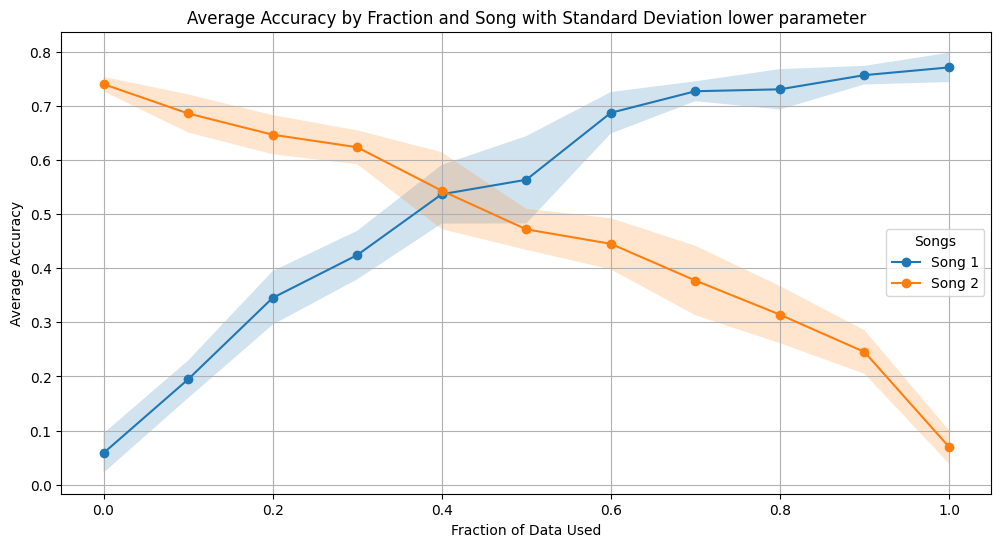

In [96]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming accuracies are already calculated and available
# Calculate the average accuracies and standard deviation across all models for each song and fraction
average_accuracies = accuracies.mean(axis=2)  # Average over the model dimension
std_dev_accuracies = accuracies.std(axis=2)  # Standard deviation over the model dimension

# Plotting the accuracies with standard deviation
plt.figure(figsize=(12, 6))
for song_idx, song in enumerate(songStrings):
    # Generate the x-values for the fractions
    x_values = fractions
    y_values = average_accuracies[:, song_idx]
    y_err = std_dev_accuracies[:, song_idx]

    plt.plot(x_values, y_values, marker='o', label=f'Song {song_idx + 1}')
    plt.fill_between(x_values, (y_values - y_err), (y_values + y_err), alpha=0.2)

plt.title('Average Accuracy by Fraction and Song with Standard Deviation lower parameter')
plt.xlabel('Fraction of Data Used')
plt.ylabel('Average Accuracy')
plt.legend(title="Songs")
plt.grid(True)
plt.show()
